In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torchvision import transforms
from ClassComp.data_utils.loaders import get_mnist, get_dataloader
from ClassComp.experiments.train import train_binary_classifier, train_vae


In [4]:
torch.cuda.is_available()

True

### VGG

In [5]:
from ClassComp.models.vgg import VGG

n_epochs = 2
batch_size = 4
# Define an optional custom transformation
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

custom_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
        transforms.RandomVerticalFlip(p=0.5),    # 50% chance of vertical flip
        transforms.RandomAffine(
            degrees=30,                          # Random rotation within ±30 degrees
            translate=(0.1, 0.1),                # Random translation up to 10% of image size
            scale=(0.9, 1.1),                    # Random scaling between 90% and 110%
            shear=10                             # Random shear within ±10 degrees
        ),
        transforms.RandomPerspective(
            distortion_scale=0.5,                # Distortion scale for perspective transform
            p=0.5                                # 50% chance of applying
        ),
        transforms.RandomErasing(
            p=0.5,                               # 50% chance of applying
            scale=(0.02, 0.2),                   # Proportion of erased area
            ratio=(0.3, 3.3),                    # Aspect ratio of erased area
            value=0                              # Fill value for erased pixels
        ),
        AddGaussianNoise(0., 1.)
    ])

# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(
    train_subset, 
    test_subset, 
    transform=custom_transforms, 
    size=64,
    batch_size=4,
    class_imbalance=0.7,
)

# Instantiate the model
model = VGG(input_img_size=64, input_img_c=1) # Black and white images

# Train the model
train_binary_classifier(model, train_loader, test_loader, epochs=n_epochs, learning_rate=1e-3)

# torch.save(model.state_dict(), f"./results/models/vgg_{n_epochs}_epochs_with_transforms.pth")


KeyboardInterrupt: 

In [4]:
del model
torch.cuda.empty_cache()

### ResNet

In [4]:
from ClassComp.models.resnet import ResNet

from ClassComp.models.vgg import VGG

n_epochs = 1
batch_size = 4

# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, batch_size=batch_size)

# Instantiate the model
model = ResNet(input_img_c=1) # Black and white images

# Train the model
train_binary_classifier(model, train_loader, test_loader, epochs=n_epochs, learning_rate=1e-3)

torch.save(model.state_dict(), f"./results/models/resnet_{n_epochs}_epochs.pth")


Epoch [1/1], Loss: 15.4990
Validation Accuracy: 99.86%


In [8]:
del model
torch.cuda.empty_cache()

### UNet

In [9]:
from ClassComp.models.resnet import ResNet
from ClassComp.models.unet import UNet

n_epochs = 10

resnet_model = ResNet()

# Load the trained weights
resnet_model.load_state_dict(torch.load(f"./results/models/resnet_{n_epochs}_epochs.pth"))
resnet_model = resnet_model.to("cuda")

# Get the DataLoaders
train_loader, test_loader = get_binary_mnist_dataloader(batch_size=3)

# Instantiate the model
model = UNet(resnet_model) 

# Train the model
train_binary_classifier(model, train_loader, test_loader, epochs=n_epochs, learning_rate=1e-3)

torch.save(model.state_dict(), f"./results/models/unet_{n_epochs}_epochs.pth")

/tmp/ipykernel_154390/57385793.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(f"./results/models/resnet_{n_epochs}_epochs.pth"))

Epoch [1/10], Loss: 0.0555
Validation Accuracy: 99.91%


Epoch [2/10], Loss: 0.0077
Validation Accuracy: 99.91%


Epoch [3/10], Loss: 0.0061
Validation Accuracy: 100.00%


Epoch [4/10], Loss: 0.0034
Validation Accuracy: 99.95%


Epoch [5/10], Loss: 0.0029
Validation Accuracy: 99.86%


Epoch [6/10], Loss: 0.0020
Validation Accuracy: 99.95%


Epoch [7/10], Loss: 0.0020
Validation Accuracy: 99.91%


Epoch [8/10], Loss: 0.0022
Validation Accuracy: 99.91%


Epoch [9/10], Loss: 0.0038
Validation Accuracy: 99.95%


Epoch [10/10], Loss: 0.0015
Validation Accuracy: 99.95%


### VAE

In [ ]:
from ClassComp.models.vae import VAE, VAE_conv, SVMLoss
from ClassComp.models.resnet import ResNet
from ClassComp.utils.visualization import plot_vae_tsne_with_svm_boundary, plot_vae_outputs, plot_vae_samples


image_size = 64
batch_size = 16
custom_transforms = None
epochs = 2
lr = 1e-3
beta = 0.05

## Get binary MNIST subsets
train_subset, test_subset = get_mnist()

## Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, transform=custom_transforms, size=image_size, batch_size=batch_size)


# resnet = ResNet(input_img_size=64, input_img_c=1) 
# resnet_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/resnet_20_epochs_0.001_lr_vanilla.pth.tar" 
# resnet.load_state_dict(torch.load(resnet_path))
# resnet.to("cuda")
# resnet.eval()


vae = VAE_conv(image_size)
vae_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/vae_20_epochs_0.001_lr_vanilla_pretrained_resnet_classification.pth.tar"
vae.load_state_dict(torch.load(vae_path))
# vae.classification_mode = False
# train_vae(vae, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=False)



vae.classification_mode = True

# Train VAE classification head
criterion = SVMLoss()
for param in vae.parameters():
    param.requires_grad = False
for name, param in vae.named_parameters():
    if "svm_layer" in name:
        param.requires_grad = True
train_binary_classifier(vae, train_loader, test_loader, criterion=criterion, epochs=epochs, learning_rate=lr, device="cuda", save_results=False)

vae.classification_mode = False

plot_vae_tsne_with_svm_boundary(vae, test_loader)

plot_vae_outputs(vae, test_loader)

plot_vae_samples(vae)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2048 and 4x8)

In [ ]:
import pickle
from ClassComp.models.vae import VAE, SVMLoss
from ClassComp.data_utils.loaders import get_mnist, get_dataloader
from ClassComp.experiments.train import train_binary_classifier, train_vae, train_vae_kmeans
from ClassComp.utils.visualization import plot_vae_tsne_with_svm_boundary, plot_vae_outputs, plot_vae_samples, plot_vae_tsne_with_kmeans


# Vanilla training

image_size = 64
batch_size = 16
custom_transforms = None
epochs = 2
lr = 1e-3
beta = 0.05
description = "vanilla"

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
custom_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # 50% chance of vertical flip
    transforms.RandomAffine(
        degrees=30,                          # Random rotation within ±30 degrees
        translate=(0.1, 0.1),                # Random translation up to 10% of image size
        scale=(0.9, 1.1),                    # Random scaling between 90% and 110%
        shear=10                             # Random shear within ±10 degrees
    ),
    transforms.RandomPerspective(
        distortion_scale=0.5,                # Distortion scale for perspective transform
        p=0.5                                # 50% chance of applying
    ),
    transforms.RandomErasing(
        p=0.5,                               # 50% chance of applying
        scale=(0.02, 0.2),                   # Proportion of erased area
        ratio=(0.3, 3.3),                    # Aspect ratio of erased area
        value=0                              # Fill value for erased pixels
    ),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Add Gaussian Blur
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Adjust sharpness
    AddGaussianNoise(),
])

## Get binary MNIST subsets
train_subset, test_subset = get_mnist()

## Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, transform=custom_transforms, size=image_size, batch_size=batch_size)


vae = VAE(image_size**2, 32*32, 8, beta=beta)
# train_vae(vae, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=False)
vae.classification_mode = "SVM"
vae_path = f"/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/vae_20_epochs_0.001_lr_vanilla_classification.pth.tar"
vae.load_state_dict(torch.load(vae_path))
vae.to("cuda")

vae.eval()  # Set the vae to evaluation mode
correct_val, total_val = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = vae(images)
        _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

epoch_val_acc = 100 * correct_val / total_val

#Train VAE classification head
# vae.classification_mode = "SVM"
# criterion = SVMLoss()
# for param in vae.parameters():
#     param.requires_grad = False
# for name, param in vae.named_parameters():
#     if "svm_layer" in name:
#         param.requires_grad = True
# train_binary_classifier(vae, train_loader, test_loader, criterion=criterion, epochs=epochs, learning_rate=lr, device="cuda", save_results=False)

# train_vae_kmeans(vae, train_loader, test_loader, "cuda", True, description)
# vae.classification_mode = "KMeans"

# with open(f"/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_{description}_kmeans.pkl", "rb") as f:
#     kmeans = pickle.load(f)
#     f.close()

# plot_vae_tsne_with_kmeans(vae, test_loader, kmeans)
# vae.classification_mode = None
# plot_vae_tsne_with_svm_boundary(vae, test_loader)

# plot_vae_outputs(vae, test_loader)

# plot_vae_samples(vae)


/tmp/ipykernel_5183/2313311030.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_path))


In [13]:
vae.classification_mode = "KMeans"
train_vae_kmeans(vae, train_loader, test_loader, "cuda", False)

0.6137115839243499
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_None_kmeans.pkl


In [10]:
epoch_val_acc

67.89598108747045

In [26]:
import pickle

with open("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/VAE_vanilla_kmeans.pkl", "rb") as f:
    d = pickle.load(f)
    f.close()

In [27]:
d

{'training_accuracy': [0.9429135412554284],
 'validation_accuracy': [0.9508274231678487],
 'training_time': [4.468583583831787]}

/tmp/ipykernel_105624/3055942220.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(f"./results/models/resnet_1_epochs.pth"))


VAE epoch 1


/tmp/ipykernel_105624/3055942220.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./results/checkpoints/vae_epoch_{e}.pth")["model_sta

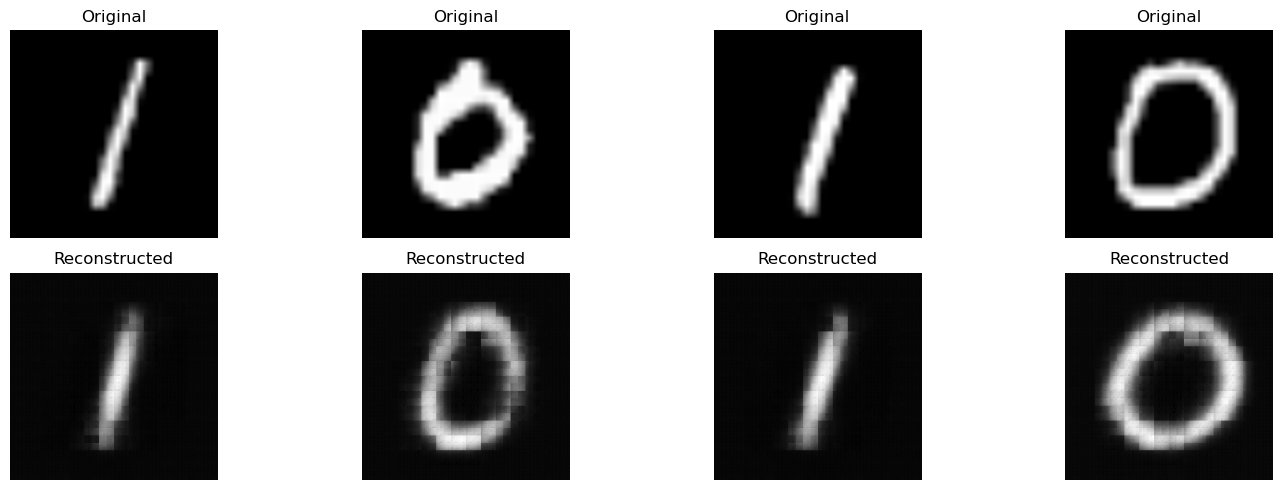

VAE epoch 2


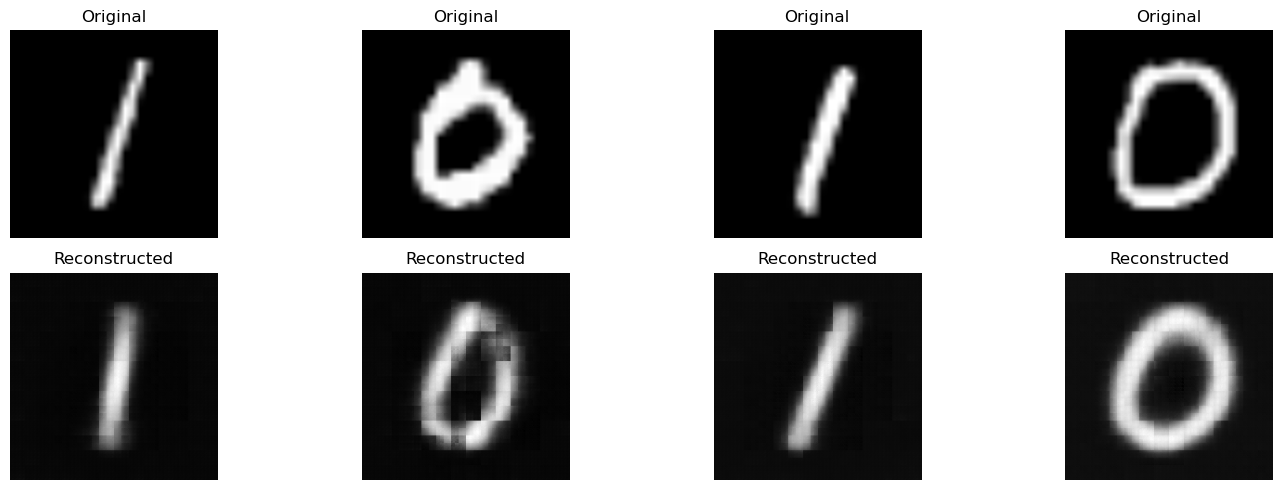

VAE epoch 3


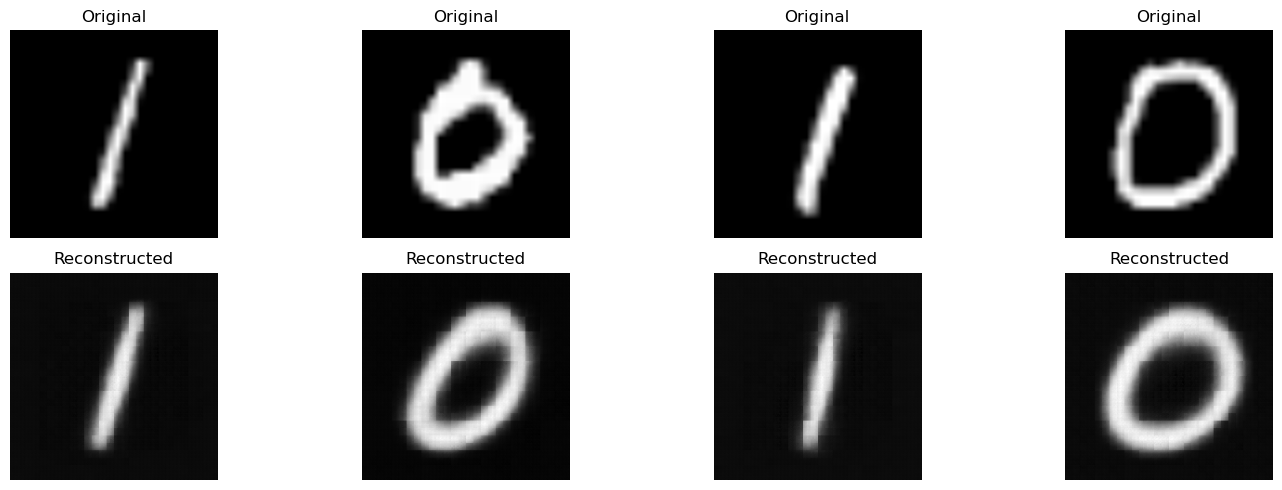

VAE epoch 4


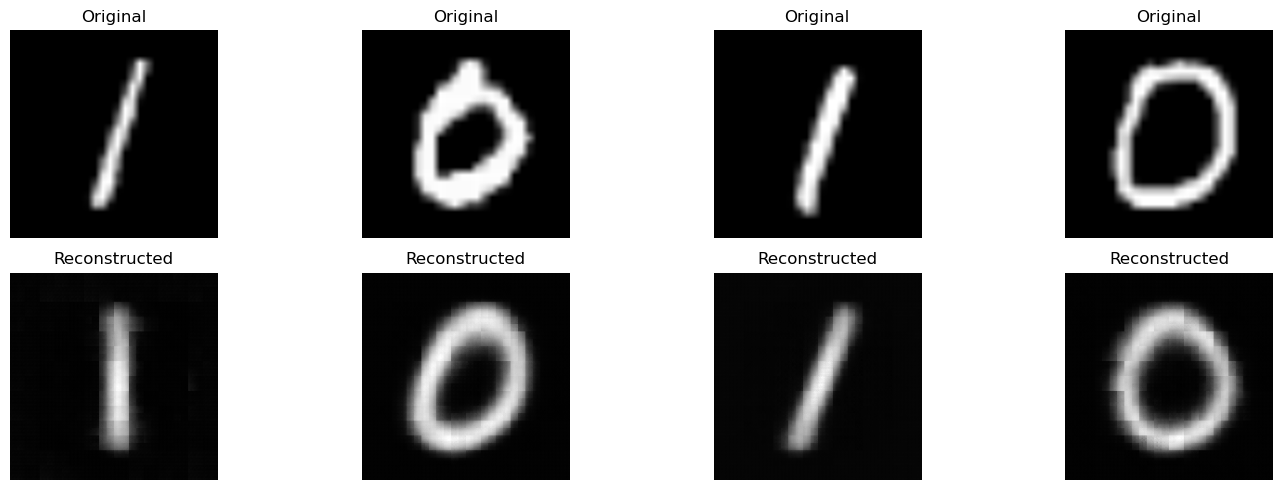

VAE epoch 5


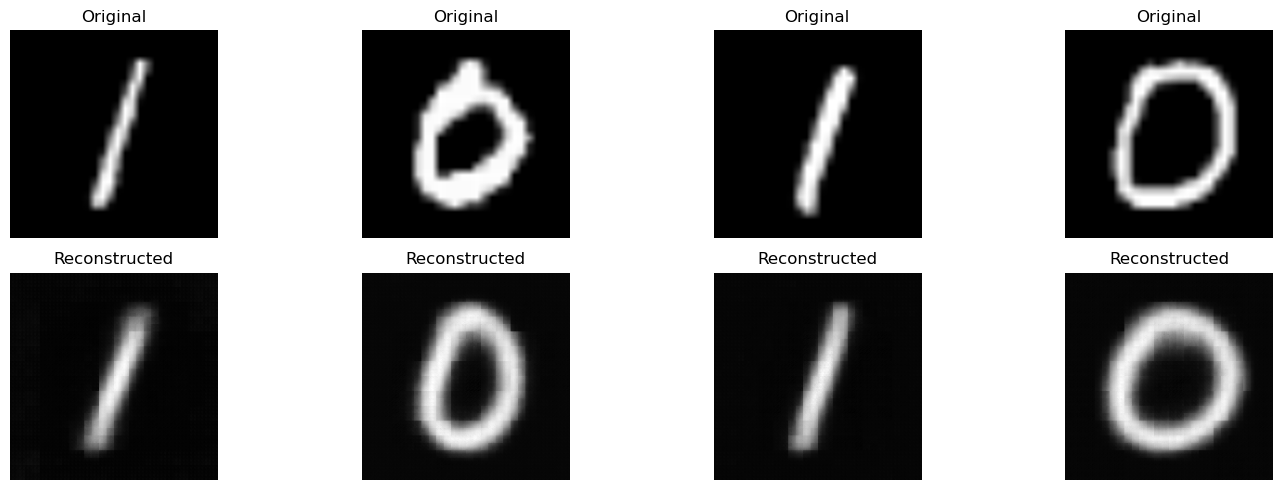

VAE epoch 6


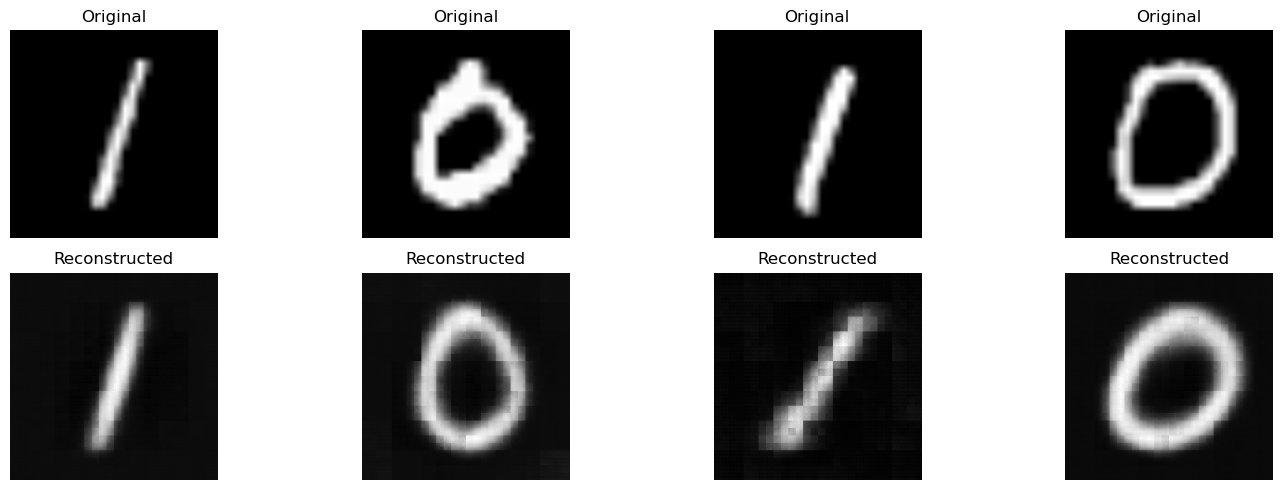

VAE epoch 7


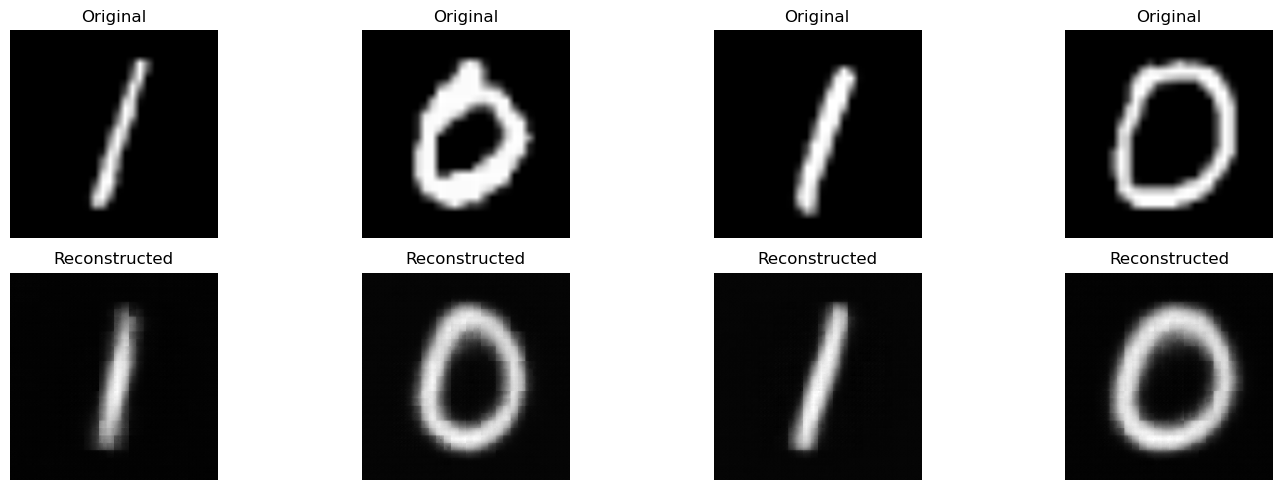

VAE epoch 8


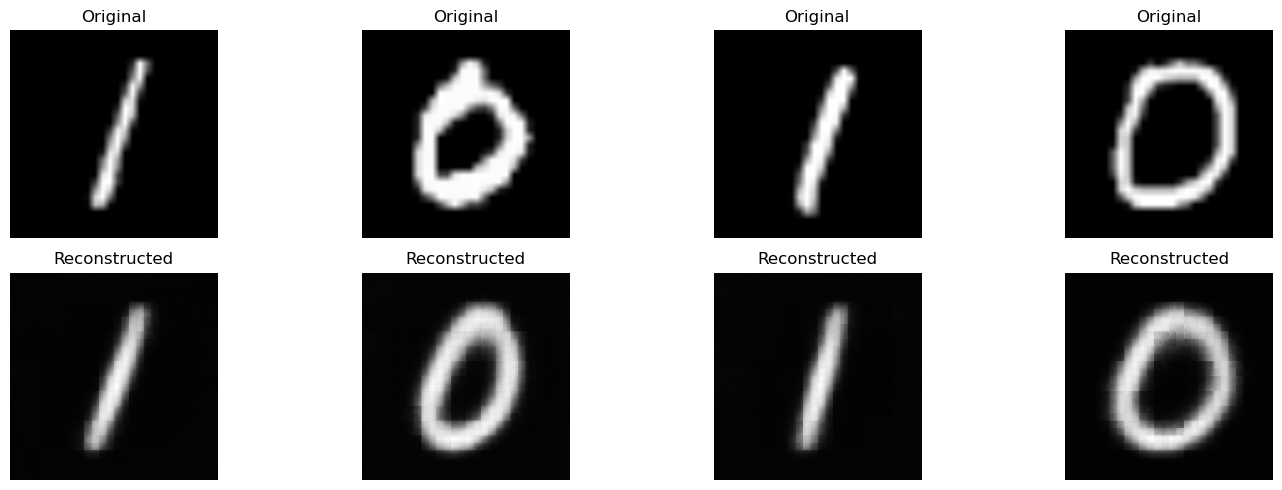

VAE epoch 9


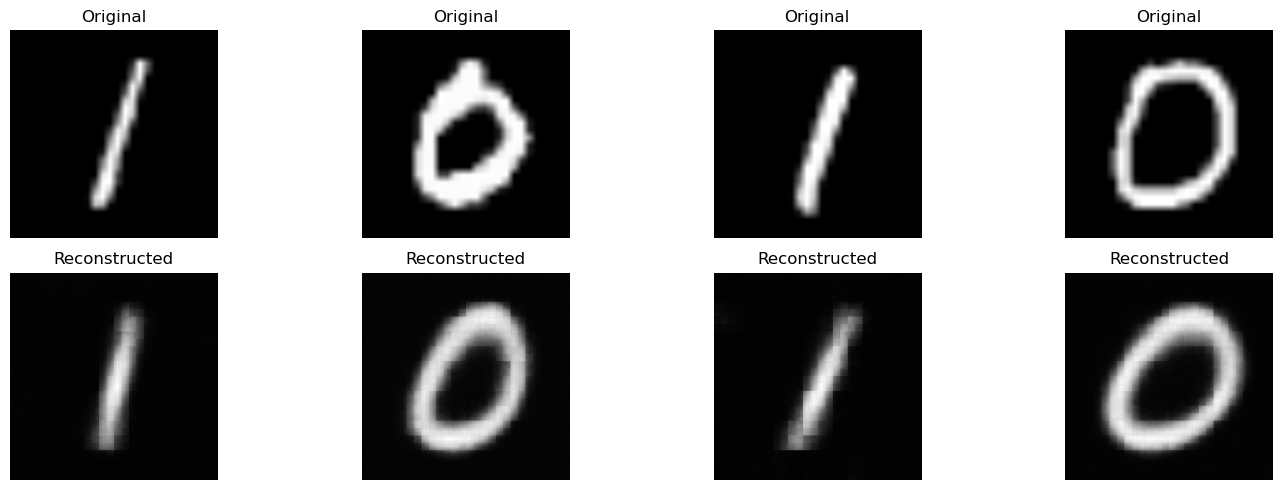

VAE epoch 10


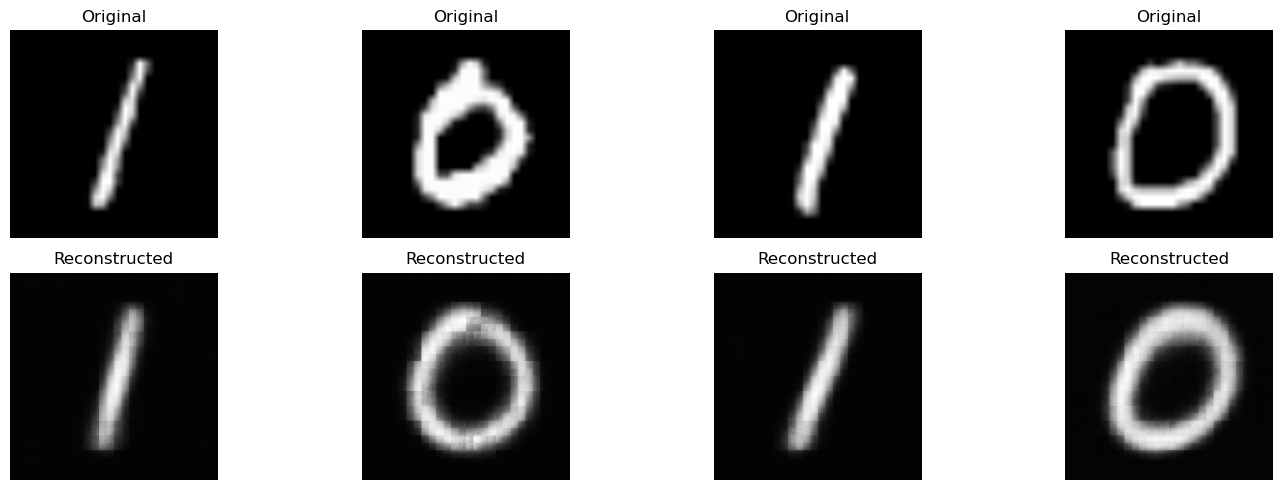

In [6]:
from ClassComp.models.vae import VAE
from ClassComp.models.resnet import ResNet

train_subset, test_subset = get_mnist()
_, test_loader = get_dataloader(train_subset, test_subset, transform=None, batch_size=4)

resnet_model = ResNet()
# Load the trained weights
resnet_model.load_state_dict(torch.load(f"./results/models/resnet_1_epochs.pth"))
resnet_model = resnet_model.to("cuda")
for e in range(1, 11, 1):
    print(f"VAE epoch {e}")
    model = VAE(resnet_model)
    # Load the trained weights
    model.load_state_dict(torch.load(f"./results/checkpoints/vae_epoch_{e}.pth")["model_state_dict"])
    model = model.to("cuda")

    plot_vae_outputs(model, test_loader, device="cuda", num_images=8)


In [7]:
def plot_vae_samples(model, num_samples=8, device="cuda"):
    """
    Visualizes the samples generated by the Variational Autoencoder (VAE).
    
    Args:
        model (torch.nn.Module): The trained VAE model.
        num_samples (int): Number of samples to visualize.
        device (str): Device to use for computation ('cuda' or 'cpu').
    """
    model.to(device)
    model.eval()

    # Generate samples
    with torch.no_grad():
        samples = model.sample(num_samples, device)

    samples = samples.cpu()

    # Plot the generated samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(samples[i].squeeze(0), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Sample {i+1}")
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_105624/1019805291.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(f"./results/models/resnet_1_epochs.pth"))


VAE epoch 1


/tmp/ipykernel_105624/1019805291.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./results/checkpoints/vae_epoch_{e}.pth")["model_sta

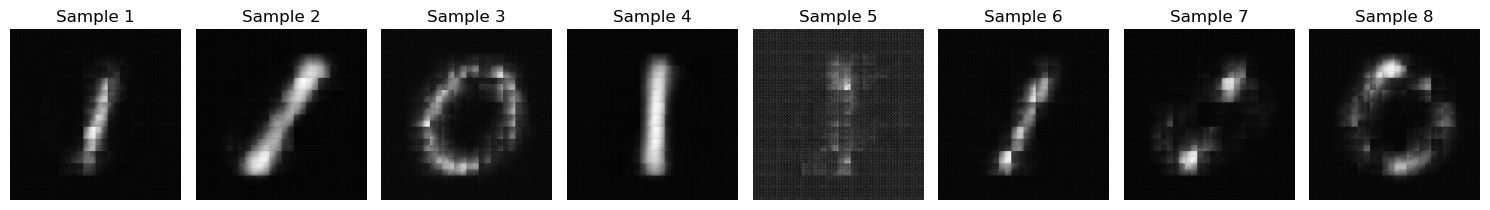

VAE epoch 2


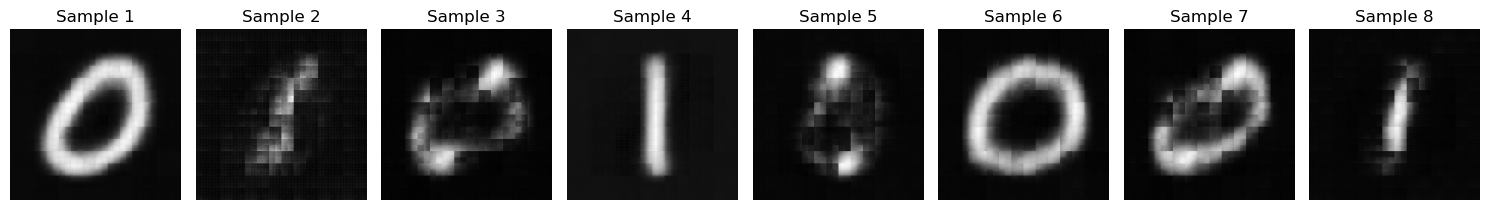

VAE epoch 3


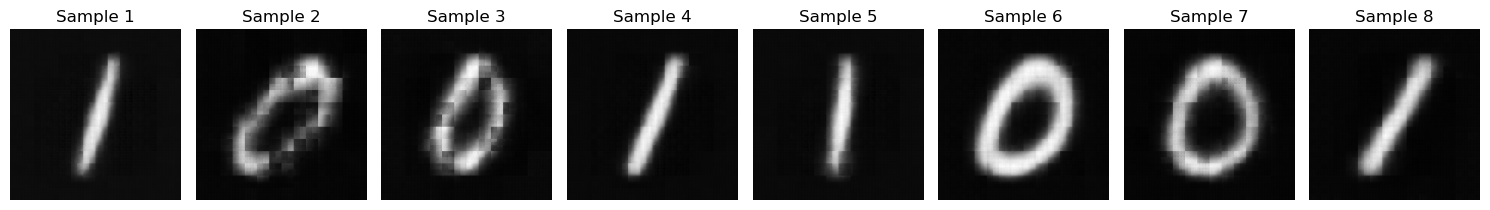

VAE epoch 4


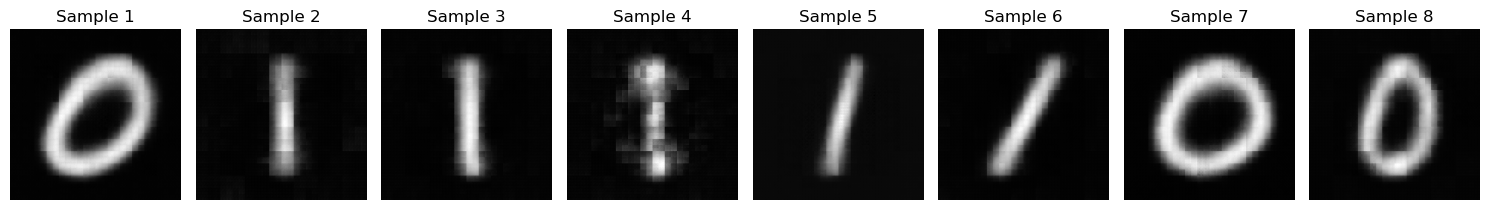

VAE epoch 5


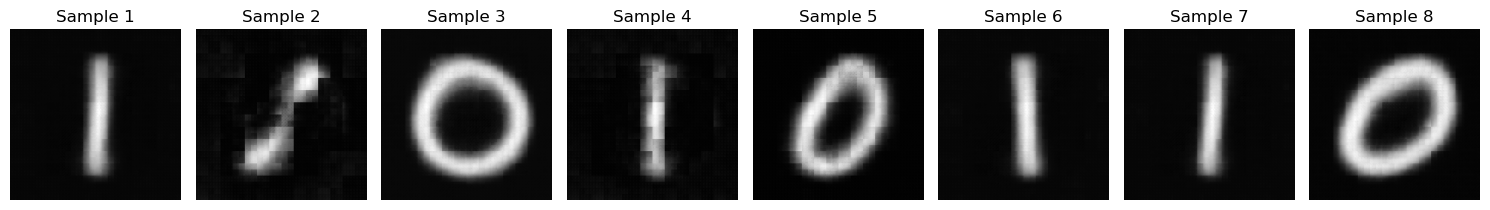

VAE epoch 6


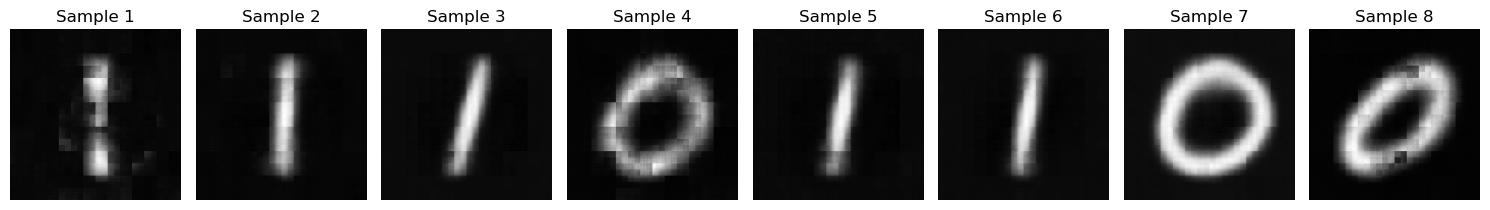

VAE epoch 7


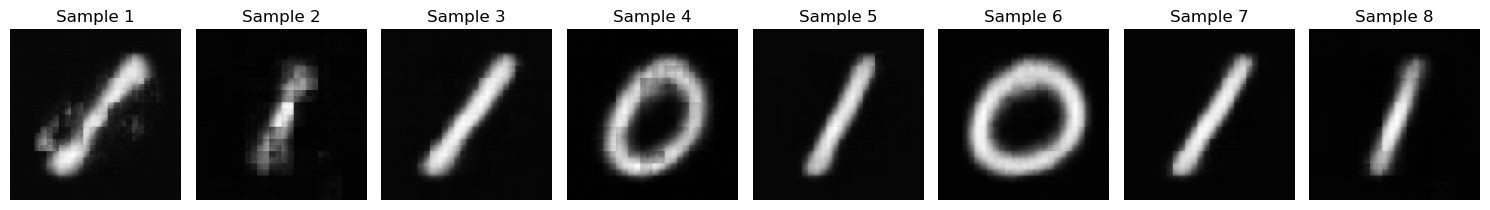

VAE epoch 8


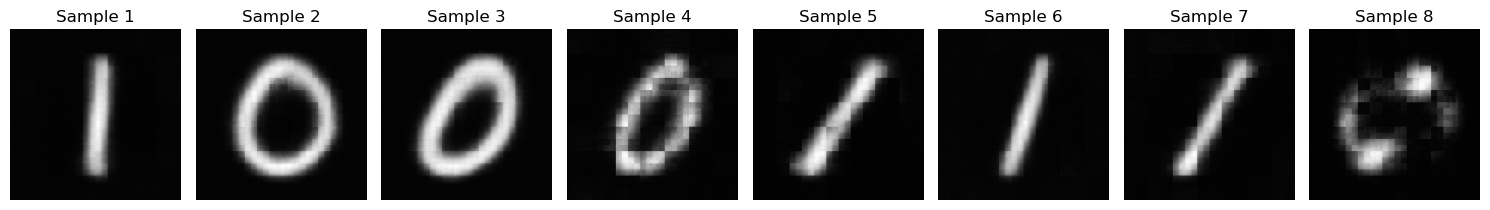

VAE epoch 9


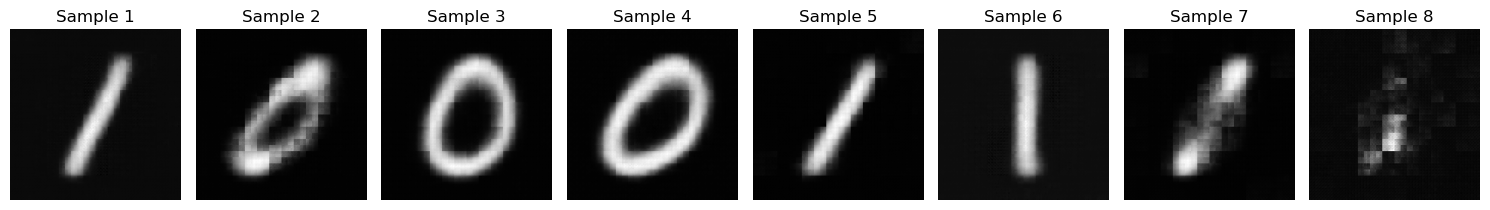

VAE epoch 10


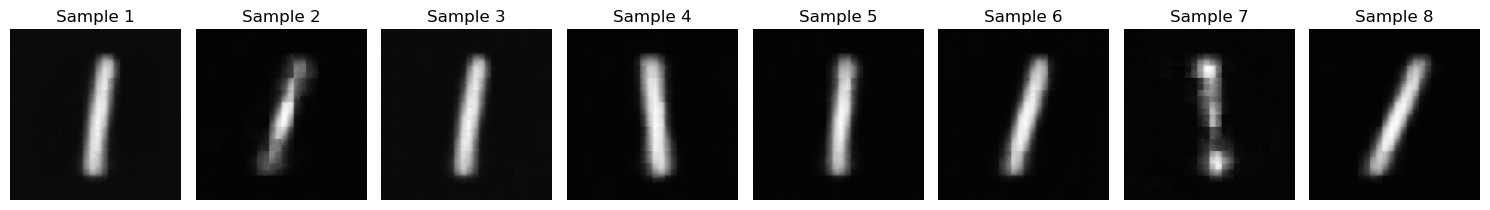

In [8]:
from ClassComp.models.vae import VAE
from ClassComp.models.resnet import ResNet

resnet_model = ResNet()
# Load the trained weights
resnet_model.load_state_dict(torch.load(f"./results/models/resnet_1_epochs.pth"))
resnet_model = resnet_model.to("cuda")
for e in range(1, 11, 1):
    print(f"VAE epoch {e}")
    model = VAE(resnet_model)
    # Load the trained weights
    model.load_state_dict(torch.load(f"./results/checkpoints/vae_epoch_{e}.pth")["model_state_dict"])
    model = model.to("cuda")

    plot_vae_samples(model, num_samples=8, device="cuda")




In [12]:
from ClassComp.models.vae import VAE, SVMLoss
from ClassComp.models.resnet import ResNet

n_epochs = 10
batch_size = 16

resnet_model = ResNet()
# Load the trained weights
resnet_model.load_state_dict(torch.load(f"./results/models/resnet_1_epochs.pth"))
resnet_model = resnet_model.to("cuda")

# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, transform=None, batch_size=4)

# Instantiate the model
model = VAE(resnet_model, classification_mode=True)
model.load_state_dict(torch.load(f"./results/checkpoints/vae_epoch_7.pth")["model_state_dict"])

# Train the classification head
criterion = SVMLoss()
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers
for name, param in model.named_parameters():
    if "svm_layer" in name:  # Example: unfreezing layers related to latent space
        param.requires_grad = True
train_binary_classifier(model, train_loader, test_loader, criterion=criterion, epochs=n_epochs, learning_rate=1e-3)

# torch.save(model.state_dict(), f"./results/models/vae_{n_epochs}_epochs_latent_8.pth")


/tmp/ipykernel_105624/1355569833.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(f"./results/models/resnet_1_epochs.pth"))
/tmp/i

Epoch [1/10], Loss: 1.1871
Validation Accuracy: 95.74%


Epoch [2/10], Loss: 0.9363
Validation Accuracy: 96.12%


Epoch [3/10], Loss: 0.9356
Validation Accuracy: 92.34%


Epoch [4/10], Loss: 0.9356
Validation Accuracy: 79.48%


Epoch [5/10], Loss: 0.9356
Validation Accuracy: 78.16%


Epoch [6/10], Loss: 0.9356
Validation Accuracy: 83.64%


Epoch [7/10], Loss: 0.9356
Validation Accuracy: 69.27%


KeyboardInterrupt: 

### Vizualization

/tmp/ipykernel_1838572/1217133763.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(vgg_path))


Visualizing filters of the first convolutional layer:


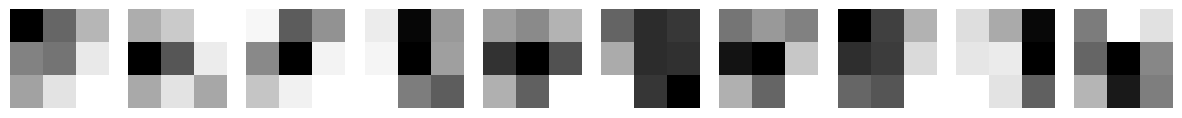

Visualizing feature maps for a sample of class '0':


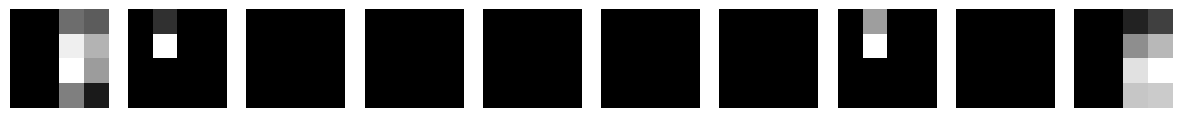

Visualizing feature maps for a sample of class '1':


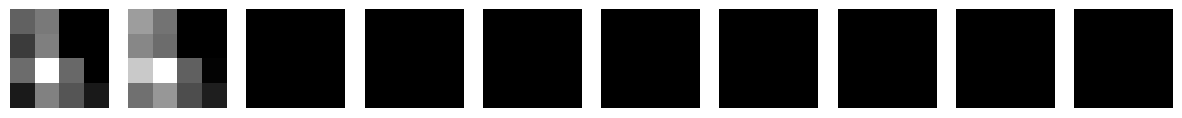

In [14]:
import torch
from ClassComp.models.vgg import VGG
from ClassComp.data_utils.loaders import get_mnist, get_dataloader

# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, size=64, batch_size=1)

# Load model
vgg = VGG(64, 1)
vgg_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/vgg_20_epochs_0.001_lr_noisy.pth.tar"
vgg.load_state_dict(torch.load(vgg_path))
vgg.eval()

# Select a sample from the dataset (one "0" and one "1")
class_zero_sample = None
class_one_sample = None

# Iterate over the train_loader to find one sample of each class
for images, labels in train_loader:
    if labels.item() == 0 and class_zero_sample is None:
        class_zero_sample = images
    elif labels.item() == 1 and class_one_sample is None:
        class_one_sample = images
    if class_zero_sample is not None and class_one_sample is not None:
        break

layer = "conv_block_5"

# Visualize Filters
print("Visualizing filters of the first convolutional layer:")
vgg.visualize_filters(
        layer_name=layer,
        inputs=class_zero_sample,
        num_filters=10,
        relevance_based=True,
        target_class=0,
    )

# Visualize Feature Maps for class "0"
print("Visualizing feature maps for a sample of class '0':")
if class_zero_sample is not None:
    vgg.visualize_feature_maps(
        layer_name=layer,
        inputs=class_zero_sample,
        num_maps=10,
        relevance_based=True,
        target_class=0,
    )

# Visualize Feature Maps for class "1"
print("Visualizing feature maps for a sample of class '1':")
if class_one_sample is not None:
    vgg.visualize_feature_maps(
        layer_name=layer,
        inputs=class_one_sample,
        num_maps=10,
        relevance_based=True,
        target_class=1,
    )




/tmp/ipykernel_2007198/3472299977.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(resnet_path))


Visualizing filters of the first convolutional layer:


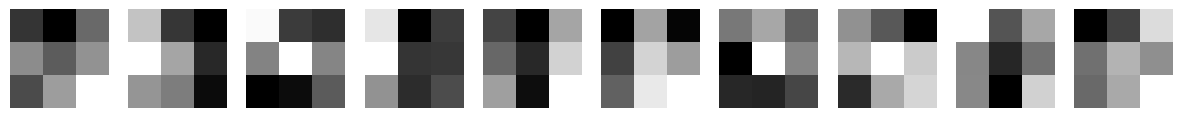

Visualizing feature maps for a sample of class '0':


/home/leo/anaconda3/envs/aml_project/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


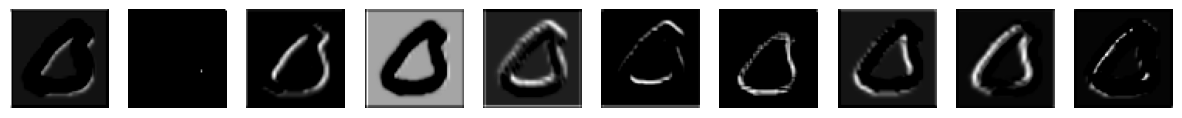

Visualizing feature maps for a sample of class '1':


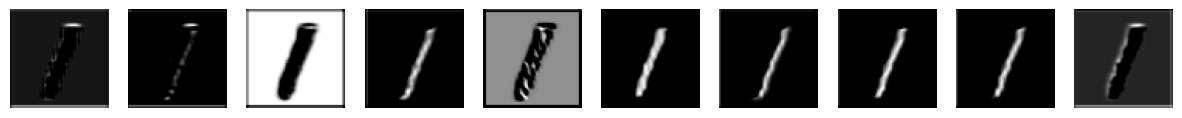

In [4]:
import torch
from ClassComp.models.resnet import ResNet
from ClassComp.data_utils.loaders import get_mnist, get_dataloader

# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, size=64, batch_size=1)

# Load model
resnet = ResNet(64, 1)
resnet_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/resnet_20_epochs_0.001_lr_noisy.pth.tar"
resnet.load_state_dict(torch.load(resnet_path))
resnet.eval()

# Select a sample from the dataset (one "0" and one "1")
class_zero_sample = None
class_one_sample = None

# Iterate over the train_loader to find one sample of each class
for images, labels in train_loader:
    if labels.item() == 0 and class_zero_sample is None:
        class_zero_sample = images
    elif labels.item() == 1 and class_one_sample is None:
        class_one_sample = images
    if class_zero_sample is not None and class_one_sample is not None:
        break

layer = "conv_block_1"

# Visualize Filters
print("Visualizing filters of the first convolutional layer:")
resnet.visualize_filters(
        layer_name=layer,
        num_filters=10,
    )

# Visualize Feature Maps for class "0"
print("Visualizing feature maps for a sample of class '0':")
if class_zero_sample is not None:
    resnet.visualize_feature_maps(
        layer_name=layer,
        inputs=class_zero_sample,
        num_maps=10,
        relevance_based=True,
        target_class=0,
    )

# Visualize Feature Maps for class "1"
print("Visualizing feature maps for a sample of class '1':")
if class_one_sample is not None:
    resnet.visualize_feature_maps(
        layer_name=layer,
        inputs=class_one_sample,
        num_maps=10,
        relevance_based=True,
        target_class=1,
    )

/tmp/ipykernel_2007198/1252419072.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(unet_path))


Visualizing filters of the first convolutional layer:


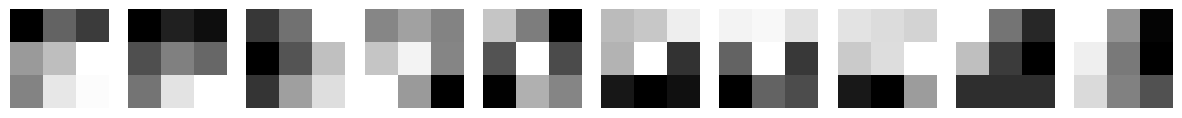

Visualizing feature maps for a sample of class '0':


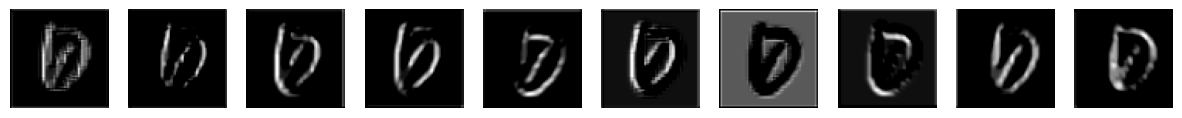

Visualizing feature maps for a sample of class '1':


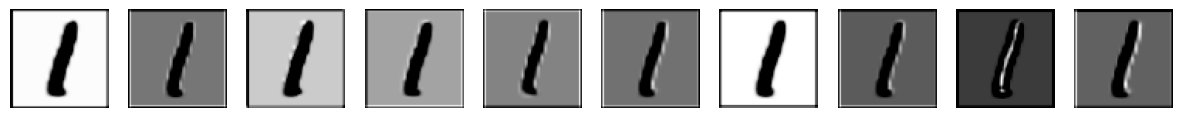

In [ ]:
import torch
from ClassComp.models.unet import UNet
from ClassComp.data_utils.loaders import get_mnist, get_dataloader

# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, size=64, batch_size=1)

# Load model
unet = UNet(64)
unet_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/unet_20_epochs_0.001_lr_noisyno_pretraining.pth.tar"
unet.load_state_dict(torch.load(unet_path))
unet.eval()

# Select a sample from the dataset (one "0" and one "1")
class_zero_sample = None
class_one_sample = None

# Iterate over the train_loader to find one sample of each class
for images, labels in train_loader:
    if labels.item() == 0 and class_zero_sample is None:
        class_zero_sample = images
    elif labels.item() == 1 and class_one_sample is None:
        class_one_sample = images
    if class_zero_sample is not None and class_one_sample is not None:
        break

layer = "conv_block_1"

# Visualize Filters
print("Visualizing filters of the first convolutional layer:")
unet.visualize_filters(
        layer_name=layer,
        num_filters=10,
    )

# Visualize Feature Maps for class "0"
print("Visualizing feature maps for a sample of class '0':")
if class_zero_sample is not None:
    unet.visualize_feature_maps(
        layer_name=layer,
        inputs=class_zero_sample,
        num_maps=10,
        relevance_based=True,
        target_class=0,
    )

# Visualize Feature Maps for class "1"
print("Visualizing feature maps for a sample of class '1':")
if class_one_sample is not None:
    unet.visualize_feature_maps(
        layer_name=layer,
        inputs=class_one_sample,
        num_maps=10,
        relevance_based=True,
        target_class=1,
    )

In [19]:

resnet = ResNet(64, 1)
resnet_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/resnet_20_epochs_0.001_lr_noisy.pth.tar"
resnet.load_state_dict(torch.load(resnet_path))
resnet.to("cuda")
unet = UNet(64, resnet)
# print(unet.conv_block_4.convs[0].weight)
unet_path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/unet_20_epochs_0.001_lr_vanilla_pretrained_resnet.pth.tar"
unet.load_state_dict(torch.load(unet_path))
# print(unet.conv_block_4.convs[0].weight)
unet.eval()
device="cuda"
unet.to(device)
correct_val, total_val = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        if resnet._get_name() == "VAE":
            _, predicted = torch.min(outputs, 1)
        else:
            _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
epoch_val_acc = 100 * correct_val / total_val
print(f"Validation Accuracy: {epoch_val_acc:.2f}%")

/tmp/ipykernel_2007198/2957358125.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(resnet_path))
/tmp/ipykernel_2007198/2957358125.py:8:

Validation Accuracy: 96.69%


### Synthetic data

In [8]:
import torch
import matplotlib.pyplot as plt
from ClassComp.data_utils.synthetic_data import generate_synthetic_dataset

# Define parameters for dataset
image_size = 224
dataset_size = 500
mu_0 = 1
mu_1 = -1
sigma_0 = sigma_1 = 1.0

# Updated dataset_mean function
def dataset_mean(subset):
    """
    Calculate the mean pixel value of a Subset dataset.

    Args:
        subset (torch.utils.data.Subset): Subset containing images and labels.

    Returns:
        float: Mean pixel value of the images in the subset.
    """
    images = torch.stack([subset.dataset[i] for i in range(len(subset))], dim=0)
    return images.mean().item()

# Iterate over seeds and compare train/test dataset statistics
for seed in range(100):  # Test a range of seeds
    train_set = generate_synthetic_dataset(
        size=dataset_size, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1,image_size=image_size, seed=seed
    )
    test_set = generate_synthetic_dataset(
        size=dataset_size, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1,image_size=image_size, seed=seed + 1
    )  # Use a different seed for test

    train_mean = dataset_mean(train_set)
    test_mean = dataset_mean(test_set)
    difference = abs(train_mean - test_mean)

    print(f"Seed {seed}: Train mean = {train_mean}, Test mean = {test_mean}, Difference = {difference}")
    if difference > 0.5:  # Arbitrary threshold for distinct datasets
        print(f"Found distinct seeds: Train seed = {seed}, Test seed = {seed + 1}")
        break


Seed 0: Train mean = -0.04824790358543396, Test mean = 0.02397921308875084, Difference = 0.0722271166741848
Seed 1: Train mean = 0.02397921308875084, Test mean = -0.024115627631545067, Difference = 0.048094840720295906
Seed 2: Train mean = -0.024115627631545067, Test mean = 0.04820051044225693, Difference = 0.072316138073802
Seed 3: Train mean = 0.04820051044225693, Test mean = -0.020224951207637787, Difference = 0.06842546164989471
Seed 4: Train mean = -0.020224951207637787, Test mean = -0.008060134947299957, Difference = 0.01216481626033783
Seed 5: Train mean = -0.008060134947299957, Test mean = 0.019577408209443092, Difference = 0.02763754315674305
Seed 6: Train mean = 0.019577408209443092, Test mean = -0.032259251922369, Difference = 0.051836660131812096
Seed 7: Train mean = -0.032259251922369, Test mean = -0.004197713918983936, Difference = 0.028061538003385067
Seed 8: Train mean = -0.004197713918983936, Test mean = 0.07575219869613647, Difference = 0.07994991261512041
Seed 9: Tra

In [ ]:
def visualize_subset(subset, num_samples=5):
    """
    Visualize a few samples from a Subset dataset.

    Args:
        subset (torch.utils.data.Subset): Subset to visualize.
        num_samples (int): Number of samples to visualize.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(subset.indices[:num_samples]):
        # Unpack the dataset entry (image and label)
        img = subset.dataset[idx]  # Correct unpacking
        label = subset.indices[idx]
        if isinstance(img, torch.Tensor):  # Check if the image needs reshaping
            img = img.view(int(torch.sqrt(torch.tensor(img.numel()))), -1)
        axes[i].imshow(img.numpy(), cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()


# Generate datasets
train_set = generate_synthetic_dataset(
    size=dataset_size, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1, image_size=image_size, seed=2
)
test_set = generate_synthetic_dataset(
    size=dataset_size, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1, image_size=image_size, seed=3
)

# Visualize train and test subsets
# visualize_subset(train_set)
# visualize_subset(test_set)


NameError: name 'dataset_size' is not defined

### Error analysis

In [21]:
from ClassComp.experiments.error_analysis import error_analysis
import pickle
import copy

def update_running_average(results, cumulative_sums, counts):
    """
    Update the running average of the results in the dictionary.

    Args:
        results (dict): The dictionary containing the current results.
        cumulative_sums (dict): The dictionary storing cumulative sums of values.
        counts (int): The current count of iterations.

    Returns:
        dict: The updated running averages.
    """
    # Update cumulative sums and counts
    for key, values in results.items():
        if key not in cumulative_sums:
            cumulative_sums[key] = [0.0] * len(values)  # Initialize sums if not present
        
        # Update cumulative sums
        for i in range(len(values)):
            cumulative_sums[key][i] += values[i]
    
    # Compute running averages
    running_averages = {}
    for key, sums in cumulative_sums.items():
        running_averages[key] = [s / counts for s in sums]
    
    return running_averages

# Example usage
n_runs = 10  # Number of runs
cumulative_sums = {}
counts = 0
final_averages = {}

for _ in range(n_runs):
    # Simulate running the function
    results = error_analysis(
        [-1, 1],
        3,
        dataset_size=10,
        image_size=32,
        batch_size=4,
        seed=counts + 1,
    )
    counts += 1
    final_averages = update_running_average(results, cumulative_sums, counts)

print("Final Averages:", final_averages)


# with open("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/errors/res_1_3.pkl", "wb") as f:
#     pickle.dump(res, f)
#     f.close()

# res = error_analysis(
#     [-0.2, 0.2],
#     3,
#     dataset_size=500,
#     image_size=32,
#     batch_size=16,
# )

# with open("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/errors/res_02_3.pkl", "wb") as f:
#     pickle.dump(res, f)
#     f.close()

Training VGG


Epoch [1/5], Loss: 3.0320, Training Accuracy: 60.00%, Time: 0.75s, Gradient Norm: 241.4063
Validation Accuracy: 49.60%


Epoch [2/5], Loss: 0.5161, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 42.4465


Validation Accuracy: 49.60%


Epoch [3/5], Loss: 0.0605, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 5.7457


Validation Accuracy: 49.80%


Epoch [4/5], Loss: 12.1492, Training Accuracy: 40.00%, Time: 0.10s, Gradient Norm: 232.2047


Validation Accuracy: 49.60%


Epoch [5/5], Loss: 2.4893, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 92.0705


Validation Accuracy: 49.60%
Training ResNet


Epoch [1/5], Loss: 6.0582, Training Accuracy: 30.00%, Time: 0.19s, Gradient Norm: 288.0524
Validation Accuracy: 49.60%


Epoch [2/5], Loss: 1.4384, Training Accuracy: 60.00%, Time: 0.10s, Gradient Norm: 89.8980


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1982, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 23.7789


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1028, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 26.0795


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0000, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.0013


Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.7457, Training Accuracy: 50.00%, Time: 0.33s, Gradient Norm: 5.2964
Validation Accuracy: 86.70%


Epoch [2/5], Loss: 0.4217, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 2.3179


Validation Accuracy: 92.10%


Epoch [3/5], Loss: 0.3665, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.9538


Validation Accuracy: 92.60%


Epoch [4/5], Loss: 0.3136, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.7059


Validation Accuracy: 92.70%


Epoch [5/5], Loss: 0.1324, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.8197


Validation Accuracy: 93.20%


Epoch [1/5], Loss: 0.3444, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 3.9931
Validation Accuracy: 99.90%


Epoch [2/5], Loss: 0.1299, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 0.9764


Validation Accuracy: 99.30%


Epoch [3/5], Loss: 0.1045, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.7840


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0892, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.6875


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2024, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 1.6858


Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 137808.4323, Reconstruction Loss: 137805.4531, KLD Loss: 59.5642, Time: 0.03s, Gradient Norm: 2.5036


Epoch [1/5], Validation Loss: 172564.4302, Validation Recon: 172549.2164, Validation KLD: 304.2783


Epoch [2/5], Training Loss: 135704.7422, Reconstruction Loss: 135048.3646, KLD Loss: 13127.5623, Time: 0.03s, Gradient Norm: 1.8901


Epoch [2/5], Validation Loss: 172351.0393, Validation Recon: 172302.5728, Validation KLD: 969.3349


Epoch [3/5], Training Loss: 212383.5182, Reconstruction Loss: 133370.6250, KLD Loss: 1580257.8770, Time: 0.03s, Gradient Norm: 1.5656


Epoch [3/5], Validation Loss: 172181.1069, Validation Recon: 172108.6423, Validation KLD: 1449.2925


Epoch [4/5], Training Loss: 133795.5911, Reconstruction Loss: 133571.1276, KLD Loss: 4489.2999, Time: 0.03s, Gradient Norm: 1.6823


Epoch [4/5], Validation Loss: 172211.6722, Validation Recon: 172162.6769, Validation KLD: 979.8984


Epoch [5/5], Training Loss: 133552.7448, Reconstruction Loss: 133439.3516, KLD Loss: 2267.8762, Time: 0.03s, Gradient Norm: 1.5799


Epoch [5/5], Validation Loss: 172156.4959, Validation Recon: 172137.2245, Validation KLD: 385.4307


Epoch [1/5], Loss: 1.3360, Training Accuracy: 60.00%, Time: 0.04s, Gradient Norm: 4.5884


Validation Accuracy: 80.80%


Epoch [2/5], Loss: 1.3578, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 5.9653


Validation Accuracy: 83.30%


Epoch [3/5], Loss: 1.5793, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 6.4754


Validation Accuracy: 84.60%


Epoch [4/5], Loss: 1.3494, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 8.3967


Validation Accuracy: 87.30%


Epoch [5/5], Loss: 1.2904, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 5.8805


Validation Accuracy: 87.80%
0.496
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7592227a1520_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 0.9144, Training Accuracy: 82.00%, Time: 7.29s, Gradient Norm: 27.7943
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.4538, Training Accuracy: 87.50%, Time: 7.18s, Gradient Norm: 10.8756
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.3812, Training Accuracy: 91.30%, Time: 7.23s, Gradient Norm: 8.5725
Validation Accuracy: 72.30%


Epoch [4/5], Loss: 0.4124, Training Accuracy: 88.60%, Time: 7.24s, Gradient Norm: 8.0985
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.3611, Training Accuracy: 90.80%, Time: 7.28s, Gradient Norm: 8.7288
Validation Accuracy: 99.70%
Training ResNet


Epoch [1/5], Loss: 1.7668, Training Accuracy: 87.10%, Time: 7.88s, Gradient Norm: 58.9390
Validation Accuracy: 99.00%


Epoch [2/5], Loss: 0.7547, Training Accuracy: 90.50%, Time: 7.83s, Gradient Norm: 23.6482
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4473, Training Accuracy: 93.40%, Time: 7.77s, Gradient Norm: 12.2594
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.7713, Training Accuracy: 92.20%, Time: 7.87s, Gradient Norm: 20.4438
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4739, Training Accuracy: 93.10%, Time: 7.92s, Gradient Norm: 11.9565
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1404, Training Accuracy: 94.20%, Time: 7.17s, Gradient Norm: 0.8519
Validation Accuracy: 94.60%


Epoch [2/5], Loss: 0.1090, Training Accuracy: 94.50%, Time: 7.16s, Gradient Norm: 0.6654
Validation Accuracy: 94.50%


Epoch [3/5], Loss: 0.1010, Training Accuracy: 94.30%, Time: 7.16s, Gradient Norm: 0.6139
Validation Accuracy: 95.10%


Epoch [4/5], Loss: 0.0969, Training Accuracy: 94.30%, Time: 7.03s, Gradient Norm: 0.5837
Validation Accuracy: 94.10%


Epoch [5/5], Loss: 0.0938, Training Accuracy: 94.30%, Time: 7.08s, Gradient Norm: 0.5649
Validation Accuracy: 94.90%


Epoch [1/5], Loss: 0.1390, Training Accuracy: 94.30%, Time: 9.65s, Gradient Norm: 1.0227
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1037, Training Accuracy: 94.30%, Time: 9.67s, Gradient Norm: 0.7262
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.0959, Training Accuracy: 94.40%, Time: 9.60s, Gradient Norm: 0.6607
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0912, Training Accuracy: 94.70%, Time: 9.76s, Gradient Norm: 0.6385
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0880, Training Accuracy: 95.00%, Time: 9.69s, Gradient Norm: 0.6198
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 166731.5598, Reconstruction Loss: 166650.0964, KLD Loss: 1629.2733, Time: 2.41s, Gradient Norm: 1.7361
Epoch [1/5], Validation Loss: 165758.0190, Validation Recon: 165751.6555, Validation KLD: 127.2610


Epoch [2/5], Training Loss: 165805.2194, Reconstruction Loss: 165799.3202, KLD Loss: 117.9730, Time: 2.29s, Gradient Norm: 1.7648
Epoch [2/5], Validation Loss: 165956.1807, Validation Recon: 165950.3707, Validation KLD: 116.2018


Epoch [3/5], Training Loss: 165762.1876, Reconstruction Loss: 165756.5956, KLD Loss: 111.8329, Time: 2.28s, Gradient Norm: 1.7656
Epoch [3/5], Validation Loss: 165782.2564, Validation Recon: 165774.7767, Validation KLD: 149.5910


Epoch [4/5], Training Loss: 193275.5633, Reconstruction Loss: 165760.6868, KLD Loss: 550297.5288, Time: 2.33s, Gradient Norm: 1.8179
Epoch [4/5], Validation Loss: 167010.8529, Validation Recon: 165893.8396, Validation KLD: 22340.2652


Epoch [5/5], Training Loss: 166061.3814, Reconstruction Loss: 165928.4335, KLD Loss: 2658.9525, Time: 2.27s, Gradient Norm: 1.8416
Epoch [5/5], Validation Loss: 165907.0883, Validation Recon: 165842.1703, Validation KLD: 1298.3580


Epoch [1/5], Loss: 0.5988, Training Accuracy: 7.70%, Time: 0.73s, Gradient Norm: 4.5343
Validation Accuracy: 13.10%


Epoch [2/5], Loss: 0.2686, Training Accuracy: 17.40%, Time: 0.76s, Gradient Norm: 4.0520
Validation Accuracy: 16.90%


Epoch [3/5], Loss: 0.1049, Training Accuracy: 21.00%, Time: 0.84s, Gradient Norm: 2.9455
Validation Accuracy: 18.00%


Epoch [4/5], Loss: 0.0962, Training Accuracy: 16.90%, Time: 0.76s, Gradient Norm: 2.6572
Validation Accuracy: 14.40%


Epoch [5/5], Loss: 0.0821, Training Accuracy: 14.80%, Time: 0.75s, Gradient Norm: 2.5779
Validation Accuracy: 13.20%
0.504
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7592227a1640_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:252: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  lhs = - (1 / sigma_0) * (x - mu_0).T @ (x - mu_0) + (1 / sigma_1) * (x - mu_1).T @ (x - mu_1)
/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). 

Training VGG


Epoch [1/5], Loss: 4.0749, Training Accuracy: 40.00%, Time: 0.10s, Gradient Norm: 221.7098
Validation Accuracy: 52.40%


Epoch [2/5], Loss: 3.2564, Training Accuracy: 30.00%, Time: 0.10s, Gradient Norm: 155.7123


Validation Accuracy: 47.60%


Epoch [3/5], Loss: 0.6465, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 80.2823


Validation Accuracy: 52.40%


Epoch [4/5], Loss: 0.5847, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 48.3963


Validation Accuracy: 47.60%


Epoch [5/5], Loss: 0.2773, Training Accuracy: 80.00%, Time: 0.12s, Gradient Norm: 13.4517


Validation Accuracy: 52.40%
Training ResNet


Epoch [1/5], Loss: 0.9234, Training Accuracy: 70.00%, Time: 0.12s, Gradient Norm: 250.0374
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 2.5777, Training Accuracy: 70.00%, Time: 0.11s, Gradient Norm: 139.7146


Validation Accuracy: 52.40%


Epoch [3/5], Loss: 4.6041, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 141.8403


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0113, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 7.8515


Validation Accuracy: 47.60%


Epoch [5/5], Loss: 10.2110, Training Accuracy: 60.00%, Time: 0.11s, Gradient Norm: 326.2318


Validation Accuracy: 47.60%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.6031, Training Accuracy: 60.00%, Time: 0.10s, Gradient Norm: 4.3090
Validation Accuracy: 94.30%


Epoch [2/5], Loss: 0.1625, Training Accuracy: 100.00%, Time: 0.11s, Gradient Norm: 1.0793


Validation Accuracy: 93.90%


Epoch [3/5], Loss: 0.1001, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.5732


Validation Accuracy: 92.50%


Epoch [4/5], Loss: 0.5319, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 2.7952


Validation Accuracy: 92.40%


Epoch [5/5], Loss: 0.0842, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.5021


Validation Accuracy: 80.10%


Epoch [1/5], Loss: 0.4120, Training Accuracy: 80.00%, Time: 0.13s, Gradient Norm: 4.2578
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.5337, Training Accuracy: 50.00%, Time: 0.12s, Gradient Norm: 3.1840


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.3557, Training Accuracy: 80.00%, Time: 0.14s, Gradient Norm: 2.1508


Validation Accuracy: 99.80%


Epoch [4/5], Loss: 0.3163, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.0260


Validation Accuracy: 99.70%


Epoch [5/5], Loss: 0.0932, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.5967


Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 140373.2500, Reconstruction Loss: 140368.4219, KLD Loss: 96.6227, Time: 0.03s, Gradient Norm: 2.6521


Epoch [1/5], Validation Loss: 171458.1248, Validation Recon: 171281.4311, Validation KLD: 3533.8695


Epoch [2/5], Training Loss: 193192.1406, Reconstruction Loss: 135296.8385, KLD Loss: 1157906.0752, Time: 0.03s, Gradient Norm: 1.6179


Epoch [2/5], Validation Loss: 171645.4617, Validation Recon: 171514.8159, Validation KLD: 2612.9238


Epoch [3/5], Training Loss: 153644.4922, Reconstruction Loss: 135070.1198, KLD Loss: 371487.4395, Time: 0.03s, Gradient Norm: 1.9230


Epoch [3/5], Validation Loss: 171716.5723, Validation Recon: 171568.2824, Validation KLD: 2965.8055


Epoch [4/5], Training Loss: 703871.8099, Reconstruction Loss: 134872.5521, KLD Loss: 11379985.0675, Time: 0.03s, Gradient Norm: 1.6862


Epoch [4/5], Validation Loss: 171788.0441, Validation Recon: 171669.9409, Validation KLD: 2362.0586


Epoch [5/5], Training Loss: 135205.3411, Reconstruction Loss: 134960.0312, KLD Loss: 4906.1499, Time: 0.03s, Gradient Norm: 1.6965


Epoch [5/5], Validation Loss: 171929.3786, Validation Recon: 171875.6064, Validation KLD: 1075.4409


Epoch [1/5], Loss: 4.9691, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 16.2188


Validation Accuracy: 52.40%


Epoch [2/5], Loss: 4.7755, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 15.4980


Validation Accuracy: 52.40%


Epoch [3/5], Loss: 4.7059, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 14.7527


Validation Accuracy: 52.40%


Epoch [4/5], Loss: 5.2006, Training Accuracy: 50.00%, Time: 0.02s, Gradient Norm: 17.3151


Validation Accuracy: 52.40%


Epoch [5/5], Loss: 4.4833, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 16.1112


Validation Accuracy: 52.40%
0.872
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4af6f60_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.2015, Training Accuracy: 77.30%, Time: 7.39s, Gradient Norm: 32.5287
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.4350, Training Accuracy: 92.90%, Time: 7.39s, Gradient Norm: 6.8456
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.8960, Training Accuracy: 79.60%, Time: 7.37s, Gradient Norm: 13.7083
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.5598, Training Accuracy: 79.60%, Time: 7.36s, Gradient Norm: 7.0209
Validation Accuracy: 95.60%


Epoch [5/5], Loss: 0.3475, Training Accuracy: 92.80%, Time: 7.41s, Gradient Norm: 4.8422
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 2.1077, Training Accuracy: 90.40%, Time: 7.90s, Gradient Norm: 68.9953
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.8633, Training Accuracy: 92.60%, Time: 7.88s, Gradient Norm: 19.6273
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.5304, Training Accuracy: 94.40%, Time: 7.98s, Gradient Norm: 12.2025
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.2618, Training Accuracy: 96.00%, Time: 7.93s, Gradient Norm: 8.0960
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4015, Training Accuracy: 95.50%, Time: 7.98s, Gradient Norm: 10.8909
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1321, Training Accuracy: 95.50%, Time: 7.13s, Gradient Norm: 0.8393
Validation Accuracy: 92.30%


Epoch [2/5], Loss: 0.1070, Training Accuracy: 95.10%, Time: 7.18s, Gradient Norm: 0.6293
Validation Accuracy: 92.40%


Epoch [3/5], Loss: 0.1022, Training Accuracy: 95.50%, Time: 7.15s, Gradient Norm: 0.6178
Validation Accuracy: 92.20%


Epoch [4/5], Loss: 0.0985, Training Accuracy: 95.60%, Time: 7.16s, Gradient Norm: 0.5816
Validation Accuracy: 91.90%


Epoch [5/5], Loss: 0.0955, Training Accuracy: 95.40%, Time: 7.10s, Gradient Norm: 0.5760
Validation Accuracy: 92.00%


Epoch [1/5], Loss: 0.1509, Training Accuracy: 94.40%, Time: 9.65s, Gradient Norm: 1.1210
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1093, Training Accuracy: 95.30%, Time: 9.74s, Gradient Norm: 0.7420
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.0987, Training Accuracy: 95.50%, Time: 9.79s, Gradient Norm: 0.6753
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0975, Training Accuracy: 95.10%, Time: 9.71s, Gradient Norm: 0.6719
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0942, Training Accuracy: 95.00%, Time: 9.64s, Gradient Norm: 0.6444
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 167500.2585, Reconstruction Loss: 167485.6364, KLD Loss: 292.4442, Time: 2.46s, Gradient Norm: 1.7550
Epoch [1/5], Validation Loss: 166836.0777, Validation Recon: 166830.4651, Validation KLD: 112.2555


Epoch [2/5], Training Loss: 166894.3147, Reconstruction Loss: 166888.6639, KLD Loss: 113.0206, Time: 2.34s, Gradient Norm: 1.7022
Epoch [2/5], Validation Loss: 166850.2002, Validation Recon: 166842.9075, Validation KLD: 145.8545


Epoch [3/5], Training Loss: 166943.6482, Reconstruction Loss: 166936.3189, KLD Loss: 146.5840, Time: 2.35s, Gradient Norm: 1.7090
Epoch [3/5], Validation Loss: 167077.4105, Validation Recon: 167072.1859, Validation KLD: 104.4832


Epoch [4/5], Training Loss: 167249.0913, Reconstruction Loss: 167242.6624, KLD Loss: 128.5800, Time: 2.35s, Gradient Norm: 1.7735
Epoch [4/5], Validation Loss: 167829.4728, Validation Recon: 167816.1844, Validation KLD: 265.7793


Epoch [5/5], Training Loss: 167276.5451, Reconstruction Loss: 167251.1731, KLD Loss: 507.4366, Time: 2.34s, Gradient Norm: 1.7863
Epoch [5/5], Validation Loss: 167347.1949, Validation Recon: 167330.8593, Validation KLD: 326.7118


Epoch [1/5], Loss: 0.1081, Training Accuracy: 15.90%, Time: 0.77s, Gradient Norm: 2.5720
Validation Accuracy: 18.60%


Epoch [2/5], Loss: 0.0181, Training Accuracy: 17.20%, Time: 0.79s, Gradient Norm: 1.8874
Validation Accuracy: 16.00%


Epoch [3/5], Loss: 0.0093, Training Accuracy: 16.90%, Time: 0.84s, Gradient Norm: 1.7019
Validation Accuracy: 14.30%


Epoch [4/5], Loss: 0.0074, Training Accuracy: 12.30%, Time: 0.75s, Gradient Norm: 1.6230
Validation Accuracy: 14.80%


Epoch [5/5], Loss: 0.0049, Training Accuracy: 14.80%, Time: 0.80s, Gradient Norm: 1.6125
Validation Accuracy: 12.20%
0.958
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4af7b90_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 2.1479, Training Accuracy: 40.00%, Time: 0.10s, Gradient Norm: 239.7893
Validation Accuracy: 49.00%


Epoch [2/5], Loss: 5.7362, Training Accuracy: 60.00%, Time: 0.10s, Gradient Norm: 159.0814


Validation Accuracy: 49.00%


Epoch [3/5], Loss: 3.3003, Training Accuracy: 30.00%, Time: 0.09s, Gradient Norm: 192.7426


Validation Accuracy: 51.00%


Epoch [4/5], Loss: 1.8645, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 104.6926


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 1.1718, Training Accuracy: 50.00%, Time: 0.12s, Gradient Norm: 78.1232


Validation Accuracy: 51.00%
Training ResNet


Epoch [1/5], Loss: 4.6374, Training Accuracy: 50.00%, Time: 0.11s, Gradient Norm: 330.6728
Validation Accuracy: 49.00%


Epoch [2/5], Loss: 5.3443, Training Accuracy: 20.00%, Time: 0.10s, Gradient Norm: 213.9208


Validation Accuracy: 51.00%


Epoch [3/5], Loss: 1.1883, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 89.9712


Validation Accuracy: 49.00%


Epoch [4/5], Loss: 2.0467, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 142.2895


Validation Accuracy: 92.10%


Epoch [5/5], Loss: 0.0002, Training Accuracy: 100.00%, Time: 0.15s, Gradient Norm: 0.0288


Validation Accuracy: 78.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.4054, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 3.4142
Validation Accuracy: 93.80%


Epoch [2/5], Loss: 0.3800, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.9664


Validation Accuracy: 93.70%


Epoch [3/5], Loss: 0.1061, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.5777


Validation Accuracy: 93.90%


Epoch [4/5], Loss: 0.3367, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.7762


Validation Accuracy: 94.10%


Epoch [5/5], Loss: 0.0911, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.5057


Validation Accuracy: 94.10%


Epoch [1/5], Loss: 0.5864, Training Accuracy: 70.00%, Time: 0.13s, Gradient Norm: 5.8826
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1192, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 0.8304


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.3715, Training Accuracy: 80.00%, Time: 0.13s, Gradient Norm: 2.2057


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0958, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 0.6375


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2943, Training Accuracy: 90.00%, Time: 0.13s, Gradient Norm: 2.2282


Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 144284.7161, Reconstruction Loss: 144244.5417, KLD Loss: 803.4156, Time: 0.03s, Gradient Norm: 2.4446


Epoch [1/5], Validation Loss: 174119.6091, Validation Recon: 170357.5573, Validation KLD: 75241.0286


Epoch [2/5], Training Loss: 523341707.9870, Reconstruction Loss: 139464.5938, KLD Loss: 10464044816.8464, Time: 0.03s, Gradient Norm: 1.6188


Epoch [2/5], Validation Loss: 169902.6183, Validation Recon: 169854.0923, Validation KLD: 970.5223


Epoch [3/5], Training Loss: 438377.2448, Reconstruction Loss: 139412.4766, KLD Loss: 5979295.3396, Time: 0.03s, Gradient Norm: 1.6241


Epoch [3/5], Validation Loss: 169805.5011, Validation Recon: 169763.9900, Validation KLD: 830.2206


Epoch [4/5], Training Loss: 139376.7500, Reconstruction Loss: 139244.3411, KLD Loss: 2648.1409, Time: 0.03s, Gradient Norm: 1.7406


Epoch [4/5], Validation Loss: 169816.4375, Validation Recon: 169786.2977, Validation KLD: 602.7994


Epoch [5/5], Training Loss: 139125.1198, Reconstruction Loss: 139043.5938, KLD Loss: 1630.5033, Time: 0.03s, Gradient Norm: 1.6843


Epoch [5/5], Validation Loss: 169616.3417, Validation Recon: 169599.2254, Validation KLD: 342.3330


Epoch [1/5], Loss: 4.6715, Training Accuracy: 0.00%, Time: 0.01s, Gradient Norm: 12.8045


Validation Accuracy: 0.70%


Epoch [2/5], Loss: 4.3260, Training Accuracy: 0.00%, Time: 0.01s, Gradient Norm: 12.9792


Validation Accuracy: 0.70%


Epoch [3/5], Loss: 4.1886, Training Accuracy: 0.00%, Time: 0.01s, Gradient Norm: 14.5815


Validation Accuracy: 0.20%


Epoch [4/5], Loss: 4.3017, Training Accuracy: 0.00%, Time: 0.01s, Gradient Norm: 14.8648


Validation Accuracy: 0.40%


Epoch [5/5], Loss: 4.1616, Training Accuracy: 0.00%, Time: 0.01s, Gradient Norm: 12.8216


Validation Accuracy: 0.50%
0.562
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f24447a0_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.2411, Training Accuracy: 77.10%, Time: 7.30s, Gradient Norm: 39.5154
Validation Accuracy: 93.20%


Epoch [2/5], Loss: 0.6131, Training Accuracy: 87.40%, Time: 7.30s, Gradient Norm: 12.2460
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4525, Training Accuracy: 90.30%, Time: 7.37s, Gradient Norm: 8.3395
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4372, Training Accuracy: 90.20%, Time: 7.38s, Gradient Norm: 8.1467
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4610, Training Accuracy: 92.30%, Time: 7.37s, Gradient Norm: 8.3910
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 1.8397, Training Accuracy: 89.20%, Time: 7.93s, Gradient Norm: 54.3999
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.9746, Training Accuracy: 91.50%, Time: 7.99s, Gradient Norm: 22.6299
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.5593, Training Accuracy: 91.80%, Time: 8.02s, Gradient Norm: 13.7671
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.3551, Training Accuracy: 94.10%, Time: 7.96s, Gradient Norm: 9.2259
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.1988, Training Accuracy: 94.10%, Time: 7.89s, Gradient Norm: 6.1542
Validation Accuracy: 94.60%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1500, Training Accuracy: 94.60%, Time: 7.15s, Gradient Norm: 0.9101
Validation Accuracy: 93.80%


Epoch [2/5], Loss: 0.1171, Training Accuracy: 94.20%, Time: 7.28s, Gradient Norm: 0.7016
Validation Accuracy: 93.50%


Epoch [3/5], Loss: 0.1077, Training Accuracy: 93.30%, Time: 7.12s, Gradient Norm: 0.6541
Validation Accuracy: 94.90%


Epoch [4/5], Loss: 0.1038, Training Accuracy: 94.00%, Time: 7.16s, Gradient Norm: 0.6373
Validation Accuracy: 93.40%


Epoch [5/5], Loss: 0.1011, Training Accuracy: 94.30%, Time: 7.24s, Gradient Norm: 0.6290
Validation Accuracy: 93.40%


Epoch [1/5], Loss: 0.1461, Training Accuracy: 93.40%, Time: 9.79s, Gradient Norm: 1.1468
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1159, Training Accuracy: 93.60%, Time: 9.78s, Gradient Norm: 0.7613
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1083, Training Accuracy: 93.70%, Time: 9.73s, Gradient Norm: 0.7207
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1029, Training Accuracy: 93.50%, Time: 9.69s, Gradient Norm: 0.6903
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.1000, Training Accuracy: 93.50%, Time: 9.73s, Gradient Norm: 0.6804
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 166923.1711, Reconstruction Loss: 166414.8158, KLD Loss: 10167.1123, Time: 2.21s, Gradient Norm: 1.7768
Epoch [1/5], Validation Loss: 165611.7470, Validation Recon: 165594.4509, Validation KLD: 345.9287


Epoch [2/5], Training Loss: 165845.2652, Reconstruction Loss: 165837.5821, KLD Loss: 153.6659, Time: 2.24s, Gradient Norm: 1.7214
Epoch [2/5], Validation Loss: 165677.1961, Validation Recon: 165663.7464, Validation KLD: 268.9908


Epoch [3/5], Training Loss: 165831.3411, Reconstruction Loss: 165821.7036, KLD Loss: 192.7518, Time: 2.22s, Gradient Norm: 1.7728
Epoch [3/5], Validation Loss: 165769.5285, Validation Recon: 165756.2977, Validation KLD: 264.6122


Epoch [4/5], Training Loss: 165939.1458, Reconstruction Loss: 165925.8416, KLD Loss: 266.0839, Time: 2.28s, Gradient Norm: 1.7833
Epoch [4/5], Validation Loss: 165864.1689, Validation Recon: 165858.8776, Validation KLD: 105.8215


Epoch [5/5], Training Loss: 165946.8348, Reconstruction Loss: 165939.1436, KLD Loss: 153.8319, Time: 2.20s, Gradient Norm: 1.7740
Epoch [5/5], Validation Loss: 165990.5726, Validation Recon: 165983.9494, Validation KLD: 132.4581


Epoch [1/5], Loss: 0.2309, Training Accuracy: 89.60%, Time: 0.76s, Gradient Norm: 3.4467
Validation Accuracy: 89.90%


Epoch [2/5], Loss: 0.0805, Training Accuracy: 90.80%, Time: 0.79s, Gradient Norm: 2.5543
Validation Accuracy: 90.50%


Epoch [3/5], Loss: 0.0481, Training Accuracy: 91.90%, Time: 0.75s, Gradient Norm: 2.3197
Validation Accuracy: 93.00%


Epoch [4/5], Loss: 0.0350, Training Accuracy: 92.20%, Time: 0.75s, Gradient Norm: 2.1787
Validation Accuracy: 94.30%


Epoch [5/5], Loss: 0.0277, Training Accuracy: 94.10%, Time: 0.73s, Gradient Norm: 2.1187
Validation Accuracy: 95.90%
0.952
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f2444dd0_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 1.8069, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 228.4657
Validation Accuracy: 50.50%


Epoch [2/5], Loss: 1.9435, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 111.5416


Validation Accuracy: 50.50%


Epoch [3/5], Loss: 4.2812, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 197.1709


Validation Accuracy: 49.50%


Epoch [4/5], Loss: 6.6161, Training Accuracy: 30.00%, Time: 0.09s, Gradient Norm: 231.4361


Validation Accuracy: 50.50%


Epoch [5/5], Loss: 3.7593, Training Accuracy: 40.00%, Time: 0.09s, Gradient Norm: 153.4621


Validation Accuracy: 50.50%
Training ResNet


Epoch [1/5], Loss: 8.1347, Training Accuracy: 30.00%, Time: 0.11s, Gradient Norm: 385.7655
Validation Accuracy: 49.50%


Epoch [2/5], Loss: 2.4727, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 225.1520


Validation Accuracy: 50.50%


Epoch [3/5], Loss: 0.0021, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.5277


Validation Accuracy: 99.60%


Epoch [4/5], Loss: 4.1569, Training Accuracy: 60.00%, Time: 0.10s, Gradient Norm: 270.4355


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 1.0695, Training Accuracy: 80.00%, Time: 0.10s, Gradient Norm: 190.7826


Validation Accuracy: 52.50%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.6301, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 4.1354
Validation Accuracy: 94.30%


Epoch [2/5], Loss: 0.1501, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.8941


Validation Accuracy: 94.30%


Epoch [3/5], Loss: 0.1798, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.0816


Validation Accuracy: 93.90%


Epoch [4/5], Loss: 0.3946, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 2.0328


Validation Accuracy: 93.90%


Epoch [5/5], Loss: 0.1514, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.8995


Validation Accuracy: 94.30%


Epoch [1/5], Loss: 0.7254, Training Accuracy: 60.00%, Time: 0.13s, Gradient Norm: 5.2299
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.3343, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 2.2283


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1474, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.9440


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4243, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.6038


Validation Accuracy: 97.30%


Epoch [5/5], Loss: 0.1690, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.1112


Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 160244.7396, Reconstruction Loss: 144834.8958, KLD Loss: 308196.8929, Time: 0.03s, Gradient Norm: 2.3591


Epoch [1/5], Validation Loss: 195421.9918, Validation Recon: 170138.9884, Validation KLD: 505660.0646


Epoch [2/5], Training Loss: 2354493744669.2031, Reconstruction Loss: 140212.2005, KLD Loss: 47089871951143.0938, Time: 0.03s, Gradient Norm: 1.5699


Epoch [2/5], Validation Loss: 170733.4516, Validation Recon: 170472.2671, Validation KLD: 5223.6854


Epoch [3/5], Training Loss: 34154298.7839, Reconstruction Loss: 140418.5026, KLD Loss: 680277606.2894, Time: 0.03s, Gradient Norm: 1.7666


Epoch [3/5], Validation Loss: 170805.1761, Validation Recon: 170765.1747, Validation KLD: 800.0229


Epoch [4/5], Training Loss: 140373.6771, Reconstruction Loss: 140176.6667, KLD Loss: 3940.1842, Time: 0.03s, Gradient Norm: 1.6102


Epoch [4/5], Validation Loss: 170885.6921, Validation Recon: 170857.5253, Validation KLD: 563.3395


Epoch [5/5], Training Loss: 140018.9297, Reconstruction Loss: 139943.3984, KLD Loss: 1510.6887, Time: 0.03s, Gradient Norm: 1.8039


Epoch [5/5], Validation Loss: 170826.2894, Validation Recon: 170815.7366, Validation KLD: 211.0592


Epoch [1/5], Loss: 0.8802, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 4.6125


Validation Accuracy: 50.50%


Epoch [2/5], Loss: 1.1515, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 6.8030


Validation Accuracy: 50.50%


Epoch [3/5], Loss: 0.8159, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 6.8624


Validation Accuracy: 50.50%


Epoch [4/5], Loss: 1.0185, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 6.1133


Validation Accuracy: 50.50%


Epoch [5/5], Loss: 1.0569, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 5.9199


Validation Accuracy: 50.50%
1.0
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591e8bcee40_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 0.9011, Training Accuracy: 77.00%, Time: 7.33s, Gradient Norm: 26.4668
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.5482, Training Accuracy: 87.80%, Time: 7.37s, Gradient Norm: 9.3113
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.5410, Training Accuracy: 89.10%, Time: 7.30s, Gradient Norm: 8.3182
Validation Accuracy: 99.80%


Epoch [4/5], Loss: 0.3869, Training Accuracy: 91.70%, Time: 7.29s, Gradient Norm: 5.4787
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4251, Training Accuracy: 90.90%, Time: 7.36s, Gradient Norm: 5.5277
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 1.3591, Training Accuracy: 88.40%, Time: 7.96s, Gradient Norm: 44.5895
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.8033, Training Accuracy: 91.20%, Time: 7.99s, Gradient Norm: 18.4924
Validation Accuracy: 99.90%


Epoch [3/5], Loss: 0.4995, Training Accuracy: 91.70%, Time: 7.78s, Gradient Norm: 12.4432
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.3758, Training Accuracy: 92.70%, Time: 7.76s, Gradient Norm: 11.2193
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2661, Training Accuracy: 93.60%, Time: 7.79s, Gradient Norm: 7.4437
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1506, Training Accuracy: 93.50%, Time: 7.04s, Gradient Norm: 0.9169
Validation Accuracy: 94.50%


Epoch [2/5], Loss: 0.1150, Training Accuracy: 93.50%, Time: 7.13s, Gradient Norm: 0.7086
Validation Accuracy: 93.40%


Epoch [3/5], Loss: 0.1084, Training Accuracy: 94.30%, Time: 7.15s, Gradient Norm: 0.6469
Validation Accuracy: 93.50%


Epoch [4/5], Loss: 0.1028, Training Accuracy: 94.00%, Time: 7.04s, Gradient Norm: 0.6366
Validation Accuracy: 93.90%


Epoch [5/5], Loss: 0.0990, Training Accuracy: 93.50%, Time: 6.98s, Gradient Norm: 0.6238
Validation Accuracy: 94.20%


Epoch [1/5], Loss: 0.1472, Training Accuracy: 93.40%, Time: 9.56s, Gradient Norm: 1.0433
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1138, Training Accuracy: 93.90%, Time: 9.60s, Gradient Norm: 0.7609
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1046, Training Accuracy: 93.60%, Time: 9.56s, Gradient Norm: 0.7120
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0986, Training Accuracy: 94.00%, Time: 9.70s, Gradient Norm: 0.6787
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0959, Training Accuracy: 94.20%, Time: 9.69s, Gradient Norm: 0.6724
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 167422.9421, Reconstruction Loss: 167401.9355, KLD Loss: 420.1348, Time: 2.22s, Gradient Norm: 1.7670
Epoch [1/5], Validation Loss: 166272.8434, Validation Recon: 166263.2604, Validation KLD: 191.6598


Epoch [2/5], Training Loss: 166343.0102, Reconstruction Loss: 166336.9561, KLD Loss: 121.0771, Time: 2.17s, Gradient Norm: 1.7318
Epoch [2/5], Validation Loss: 166298.2570, Validation Recon: 166291.9245, Validation KLD: 126.6516


Epoch [3/5], Training Loss: 166321.8797, Reconstruction Loss: 166316.1306, KLD Loss: 114.9855, Time: 2.23s, Gradient Norm: 1.7103
Epoch [3/5], Validation Loss: 166430.3086, Validation Recon: 166425.5981, Validation KLD: 94.2172


Epoch [4/5], Training Loss: 166638.3794, Reconstruction Loss: 166628.4377, KLD Loss: 198.8456, Time: 2.16s, Gradient Norm: 1.7522
Epoch [4/5], Validation Loss: 166624.7441, Validation Recon: 166532.1834, Validation KLD: 1851.2019


Epoch [5/5], Training Loss: 166713.5635, Reconstruction Loss: 166608.1167, KLD Loss: 2108.9375, Time: 2.19s, Gradient Norm: 1.7370
Epoch [5/5], Validation Loss: 212417.1124, Validation Recon: 166751.1013, Validation KLD: 913320.2002


Epoch [1/5], Loss: 1.5565, Training Accuracy: 84.40%, Time: 0.74s, Gradient Norm: 7.5926
Validation Accuracy: 85.60%


Epoch [2/5], Loss: 2.6172, Training Accuracy: 87.60%, Time: 0.72s, Gradient Norm: 11.9201
Validation Accuracy: 90.20%


Epoch [3/5], Loss: 0.0857, Training Accuracy: 88.10%, Time: 0.77s, Gradient Norm: 2.1844
Validation Accuracy: 86.70%


Epoch [4/5], Loss: 0.0749, Training Accuracy: 87.40%, Time: 0.74s, Gradient Norm: 2.0978
Validation Accuracy: 88.00%


Epoch [5/5], Loss: 0.0601, Training Accuracy: 85.50%, Time: 0.75s, Gradient Norm: 1.9912
Validation Accuracy: 84.60%
0.506
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591e8bccda0_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 9.2291, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 222.8765
Validation Accuracy: 49.50%


Epoch [2/5], Loss: 3.5265, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 109.9340


Validation Accuracy: 50.50%


Epoch [3/5], Loss: 1.9964, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 72.5053


Validation Accuracy: 49.50%


Epoch [4/5], Loss: 0.4826, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 13.2518


Validation Accuracy: 49.50%


Epoch [5/5], Loss: 3.7775, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 150.7469


Validation Accuracy: 50.50%
Training ResNet


Epoch [1/5], Loss: 4.7455, Training Accuracy: 50.00%, Time: 0.11s, Gradient Norm: 346.0916
Validation Accuracy: 49.50%


Epoch [2/5], Loss: 4.9254, Training Accuracy: 60.00%, Time: 0.10s, Gradient Norm: 173.2974


Validation Accuracy: 49.50%


Epoch [3/5], Loss: 3.1453, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 305.2412


Validation Accuracy: 61.30%


Epoch [4/5], Loss: 2.6082, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 147.6186


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.1270, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 16.4407


Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.6623, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 4.5223
Validation Accuracy: 94.00%


Epoch [2/5], Loss: 0.4385, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 2.3663


Validation Accuracy: 94.10%


Epoch [3/5], Loss: 0.3471, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 1.7725


Validation Accuracy: 94.00%


Epoch [4/5], Loss: 0.3154, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.6865


Validation Accuracy: 94.00%


Epoch [5/5], Loss: 0.1237, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.7192


Validation Accuracy: 93.80%


Epoch [1/5], Loss: 0.5842, Training Accuracy: 80.00%, Time: 0.13s, Gradient Norm: 4.4845
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.3460, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.3362


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.5306, Training Accuracy: 70.00%, Time: 0.12s, Gradient Norm: 3.0044


Validation Accuracy: 67.60%


Epoch [4/5], Loss: 0.1154, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.8000


Validation Accuracy: 50.50%


Epoch [5/5], Loss: 0.6499, Training Accuracy: 70.00%, Time: 0.12s, Gradient Norm: 3.8872


Validation Accuracy: 50.50%
Training VAE


Epoch [1/5], Training Loss: 145750.2552, Reconstruction Loss: 145746.1510, KLD Loss: 82.0995, Time: 0.03s, Gradient Norm: 2.5598


Epoch [1/5], Validation Loss: 170809.9765, Validation Recon: 170723.0274, Validation KLD: 1738.9887


Epoch [2/5], Training Loss: 2110260.5417, Reconstruction Loss: 140529.3854, KLD Loss: 39394621.5496, Time: 0.03s, Gradient Norm: 1.5411


Epoch [2/5], Validation Loss: 169813.3186, Validation Recon: 169679.9950, Validation KLD: 2666.4750


Epoch [3/5], Training Loss: 140447.6458, Reconstruction Loss: 139580.4010, KLD Loss: 17344.8343, Time: 0.03s, Gradient Norm: 1.7330


Epoch [3/5], Validation Loss: 169853.4216, Validation Recon: 169685.8625, Validation KLD: 3351.1841


Epoch [4/5], Training Loss: 139944.5938, Reconstruction Loss: 139521.3438, KLD Loss: 8464.9155, Time: 0.03s, Gradient Norm: 1.8338


Epoch [4/5], Validation Loss: 169729.5520, Validation Recon: 169669.5424, Validation KLD: 1200.1944


Epoch [5/5], Training Loss: 139600.0391, Reconstruction Loss: 139492.3021, KLD Loss: 2154.7395, Time: 0.03s, Gradient Norm: 1.7608


Epoch [5/5], Validation Loss: 169639.1344, Validation Recon: 169629.7671, Validation KLD: 187.3405


Epoch [1/5], Loss: 1.8316, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 6.1947
Validation Accuracy: 50.80%


Epoch [2/5], Loss: 1.9650, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 5.8840
Validation Accuracy: 50.50%


Epoch [3/5], Loss: 1.9387, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 7.2239


Validation Accuracy: 52.00%


Epoch [4/5], Loss: 2.0822, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 5.9738


Validation Accuracy: 52.10%


Epoch [5/5], Loss: 1.7864, Training Accuracy: 70.00%, Time: 0.01s, Gradient Norm: 7.9774


Validation Accuracy: 51.00%
0.504
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f2444dd0_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.1940, Training Accuracy: 79.10%, Time: 7.33s, Gradient Norm: 43.3557
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.6593, Training Accuracy: 88.60%, Time: 7.23s, Gradient Norm: 14.1227
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4753, Training Accuracy: 92.20%, Time: 7.31s, Gradient Norm: 8.4231
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.3919, Training Accuracy: 92.00%, Time: 7.45s, Gradient Norm: 6.8008
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4622, Training Accuracy: 91.40%, Time: 7.32s, Gradient Norm: 7.8121
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 2.0201, Training Accuracy: 89.50%, Time: 7.72s, Gradient Norm: 49.3797
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.8658, Training Accuracy: 92.00%, Time: 7.79s, Gradient Norm: 23.6966
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 1.0170, Training Accuracy: 92.70%, Time: 7.90s, Gradient Norm: 18.7704
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4728, Training Accuracy: 93.90%, Time: 7.90s, Gradient Norm: 9.9965
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4366, Training Accuracy: 94.40%, Time: 7.85s, Gradient Norm: 10.3948
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1464, Training Accuracy: 94.00%, Time: 7.27s, Gradient Norm: 0.9065
Validation Accuracy: 93.80%


Epoch [2/5], Loss: 0.1153, Training Accuracy: 94.00%, Time: 7.23s, Gradient Norm: 0.7043
Validation Accuracy: 93.70%


Epoch [3/5], Loss: 0.1078, Training Accuracy: 94.00%, Time: 7.25s, Gradient Norm: 0.6741
Validation Accuracy: 93.80%


Epoch [4/5], Loss: 0.1052, Training Accuracy: 94.00%, Time: 7.13s, Gradient Norm: 0.6471
Validation Accuracy: 93.60%


Epoch [5/5], Loss: 0.1025, Training Accuracy: 94.40%, Time: 7.08s, Gradient Norm: 0.6297
Validation Accuracy: 93.90%


Epoch [1/5], Loss: 0.1399, Training Accuracy: 93.80%, Time: 9.63s, Gradient Norm: 1.0130
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1125, Training Accuracy: 94.20%, Time: 9.57s, Gradient Norm: 0.7487
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1059, Training Accuracy: 93.40%, Time: 9.57s, Gradient Norm: 0.7059
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1000, Training Accuracy: 94.60%, Time: 9.78s, Gradient Norm: 0.6715
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0949, Training Accuracy: 94.30%, Time: 9.67s, Gradient Norm: 0.6404
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 167947.4015, Reconstruction Loss: 167286.7536, KLD Loss: 13212.9609, Time: 2.20s, Gradient Norm: 1.7607
Epoch [1/5], Validation Loss: 165836.6931, Validation Recon: 165826.2084, Validation KLD: 209.7050


Epoch [2/5], Training Loss: 165924.0657, Reconstruction Loss: 165917.3453, KLD Loss: 134.4082, Time: 2.21s, Gradient Norm: 1.7132
Epoch [2/5], Validation Loss: 165837.1976, Validation Recon: 165831.8877, Validation KLD: 106.1997


Epoch [3/5], Training Loss: 165886.8784, Reconstruction Loss: 165880.8962, KLD Loss: 119.6370, Time: 2.20s, Gradient Norm: 1.7465
Epoch [3/5], Validation Loss: 165882.0979, Validation Recon: 165874.6964, Validation KLD: 148.0275


Epoch [4/5], Training Loss: 165903.0500, Reconstruction Loss: 165896.1514, KLD Loss: 137.9858, Time: 2.20s, Gradient Norm: 1.7990
Epoch [4/5], Validation Loss: 165937.5825, Validation Recon: 165929.0124, Validation KLD: 171.4019


Epoch [5/5], Training Loss: 165927.8047, Reconstruction Loss: 165918.9624, KLD Loss: 176.8406, Time: 2.17s, Gradient Norm: 1.7927
Epoch [5/5], Validation Loss: 166925.8329, Validation Recon: 166049.0581, Validation KLD: 17535.4935


Epoch [1/5], Loss: 1.0579, Training Accuracy: 5.10%, Time: 0.76s, Gradient Norm: 6.1049
Validation Accuracy: 6.60%


Epoch [2/5], Loss: 0.5448, Training Accuracy: 9.70%, Time: 0.74s, Gradient Norm: 4.2086
Validation Accuracy: 10.40%


Epoch [3/5], Loss: 0.2256, Training Accuracy: 10.00%, Time: 0.76s, Gradient Norm: 3.0719
Validation Accuracy: 11.20%


Epoch [4/5], Loss: 0.6359, Training Accuracy: 15.40%, Time: 0.84s, Gradient Norm: 4.7290
Validation Accuracy: 15.30%


Epoch [5/5], Loss: 0.1771, Training Accuracy: 17.40%, Time: 0.80s, Gradient Norm: 2.6176
Validation Accuracy: 17.30%
0.505
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f2445a30_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 3.5162, Training Accuracy: 30.00%, Time: 0.10s, Gradient Norm: 260.5099
Validation Accuracy: 50.50%


Epoch [2/5], Loss: 0.5186, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 15.3201


Validation Accuracy: 50.50%


Epoch [3/5], Loss: 0.3860, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 8.7211


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.2920, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 12.1151


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.7353, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 68.1096


Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 2.7176, Training Accuracy: 40.00%, Time: 0.11s, Gradient Norm: 261.6354
Validation Accuracy: 49.50%


Epoch [2/5], Loss: 2.1123, Training Accuracy: 30.00%, Time: 0.10s, Gradient Norm: 152.6516


Validation Accuracy: 50.50%


Epoch [3/5], Loss: 0.1083, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 64.5693


Validation Accuracy: 65.50%


Epoch [4/5], Loss: 0.0095, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 4.5338


Validation Accuracy: 99.90%


Epoch [5/5], Loss: 22.8685, Training Accuracy: 80.00%, Time: 0.10s, Gradient Norm: 306.2279


Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.3459, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 3.3176
Validation Accuracy: 92.90%


Epoch [2/5], Loss: 0.2605, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.5358


Validation Accuracy: 92.80%


Epoch [3/5], Loss: 0.2264, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.3255


Validation Accuracy: 93.30%


Epoch [4/5], Loss: 0.0756, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.5135


Validation Accuracy: 93.60%


Epoch [5/5], Loss: 0.0738, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.5125


Validation Accuracy: 92.80%


Epoch [1/5], Loss: 0.6832, Training Accuracy: 60.00%, Time: 0.13s, Gradient Norm: 5.6657
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.4611, Training Accuracy: 80.00%, Time: 0.12s, Gradient Norm: 2.7699


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.7528, Training Accuracy: 50.00%, Time: 0.12s, Gradient Norm: 4.4051


Validation Accuracy: 50.50%


Epoch [4/5], Loss: 0.1853, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.3937


Validation Accuracy: 50.50%


Epoch [5/5], Loss: 0.3784, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.1997


Validation Accuracy: 50.50%
Training VAE


Epoch [1/5], Training Loss: 146669.5885, Reconstruction Loss: 146659.3333, KLD Loss: 205.0476, Time: 0.03s, Gradient Norm: 2.6726


Epoch [1/5], Validation Loss: 175782.7672, Validation Recon: 169894.1465, Validation KLD: 117772.4088


Epoch [2/5], Training Loss: 2911662578.0417, Reconstruction Loss: 140840.3021, KLD Loss: 58230435953.3333, Time: 0.03s, Gradient Norm: 1.4609


Epoch [2/5], Validation Loss: 170781.0980, Validation Recon: 170310.7598, Validation KLD: 9406.7701


Epoch [3/5], Training Loss: 27032162.8229, Reconstruction Loss: 140846.5312, KLD Loss: 537826311.1123, Time: 0.03s, Gradient Norm: 1.5466


Epoch [3/5], Validation Loss: 170800.2209, Validation Recon: 170561.1010, Validation KLD: 4782.3923


Epoch [4/5], Training Loss: 141536.2812, Reconstruction Loss: 140998.6771, KLD Loss: 10752.0701, Time: 0.03s, Gradient Norm: 1.6221


Epoch [4/5], Validation Loss: 170904.1589, Validation Recon: 170799.2026, Validation KLD: 2099.1249


Epoch [5/5], Training Loss: 141040.0182, Reconstruction Loss: 140806.0234, KLD Loss: 4679.9694, Time: 0.03s, Gradient Norm: 1.5133


Epoch [5/5], Validation Loss: 170920.4762, Validation Recon: 170896.9211, Validation KLD: 471.1062


Epoch [1/5], Loss: 3.3972, Training Accuracy: 10.00%, Time: 0.01s, Gradient Norm: 11.1119


Validation Accuracy: 49.50%


Epoch [2/5], Loss: 3.7015, Training Accuracy: 10.00%, Time: 0.01s, Gradient Norm: 12.0618


Validation Accuracy: 49.50%


Epoch [3/5], Loss: 3.6817, Training Accuracy: 10.00%, Time: 0.01s, Gradient Norm: 12.1746


Validation Accuracy: 49.50%


Epoch [4/5], Loss: 3.2644, Training Accuracy: 10.00%, Time: 0.01s, Gradient Norm: 11.2807


Validation Accuracy: 49.50%


Epoch [5/5], Loss: 3.7248, Training Accuracy: 10.00%, Time: 0.01s, Gradient Norm: 13.3782


Validation Accuracy: 49.50%
0.507
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f235fc50_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 0.9191, Training Accuracy: 77.30%, Time: 7.40s, Gradient Norm: 27.4783
Validation Accuracy: 50.60%


Epoch [2/5], Loss: 0.5279, Training Accuracy: 87.10%, Time: 7.37s, Gradient Norm: 11.4798
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.5398, Training Accuracy: 87.30%, Time: 7.26s, Gradient Norm: 10.6027
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4894, Training Accuracy: 89.90%, Time: 7.37s, Gradient Norm: 8.4456
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.3940, Training Accuracy: 90.10%, Time: 7.36s, Gradient Norm: 6.9375
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 1.3424, Training Accuracy: 89.10%, Time: 7.83s, Gradient Norm: 39.0931
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.8799, Training Accuracy: 91.40%, Time: 7.85s, Gradient Norm: 22.2009
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4531, Training Accuracy: 92.70%, Time: 7.86s, Gradient Norm: 13.9365
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.6341, Training Accuracy: 93.20%, Time: 7.89s, Gradient Norm: 16.0355
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4094, Training Accuracy: 94.20%, Time: 7.82s, Gradient Norm: 9.9124
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1594, Training Accuracy: 94.70%, Time: 7.19s, Gradient Norm: 0.9570
Validation Accuracy: 93.60%


Epoch [2/5], Loss: 0.1289, Training Accuracy: 94.10%, Time: 7.02s, Gradient Norm: 0.7480
Validation Accuracy: 94.00%


Epoch [3/5], Loss: 0.1218, Training Accuracy: 94.00%, Time: 7.11s, Gradient Norm: 0.6905
Validation Accuracy: 94.00%


Epoch [4/5], Loss: 0.1189, Training Accuracy: 94.30%, Time: 7.07s, Gradient Norm: 0.6799
Validation Accuracy: 93.70%


Epoch [5/5], Loss: 0.1175, Training Accuracy: 94.20%, Time: 7.10s, Gradient Norm: 0.6777
Validation Accuracy: 93.80%


Epoch [1/5], Loss: 0.1584, Training Accuracy: 93.90%, Time: 9.61s, Gradient Norm: 1.0862
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1268, Training Accuracy: 94.50%, Time: 9.66s, Gradient Norm: 0.8360
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1234, Training Accuracy: 93.90%, Time: 9.75s, Gradient Norm: 0.7740
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1190, Training Accuracy: 94.10%, Time: 9.56s, Gradient Norm: 0.7399
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.1149, Training Accuracy: 93.90%, Time: 9.62s, Gradient Norm: 0.7117
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 167720.0485, Reconstruction Loss: 167678.6768, KLD Loss: 827.4304, Time: 2.23s, Gradient Norm: 1.8079
Epoch [1/5], Validation Loss: 166595.1858, Validation Recon: 166587.1862, Validation KLD: 160.0007


Epoch [2/5], Training Loss: 166583.7533, Reconstruction Loss: 166577.1621, KLD Loss: 131.8207, Time: 2.14s, Gradient Norm: 1.8030
Epoch [2/5], Validation Loss: 166614.4561, Validation Recon: 166606.2501, Validation KLD: 164.1283


Epoch [3/5], Training Loss: 166521.1478, Reconstruction Loss: 166515.1248, KLD Loss: 120.4667, Time: 2.31s, Gradient Norm: 1.7934
Epoch [3/5], Validation Loss: 166703.4566, Validation Recon: 166698.8834, Validation KLD: 91.4672


Epoch [4/5], Training Loss: 166690.0388, Reconstruction Loss: 166681.1567, KLD Loss: 177.6500, Time: 2.24s, Gradient Norm: 1.7967
Epoch [4/5], Validation Loss: 167417.0914, Validation Recon: 167408.7969, Validation KLD: 165.8950


Epoch [5/5], Training Loss: 167054.7436, Reconstruction Loss: 167042.9624, KLD Loss: 235.6208, Time: 2.21s, Gradient Norm: 1.8085
Epoch [5/5], Validation Loss: 169429.1310, Validation Recon: 167358.7842, Validation KLD: 41406.9271


Epoch [1/5], Loss: 1.1270, Training Accuracy: 92.60%, Time: 0.77s, Gradient Norm: 6.9633
Validation Accuracy: 91.20%


Epoch [2/5], Loss: 0.0922, Training Accuracy: 93.80%, Time: 0.78s, Gradient Norm: 3.2608
Validation Accuracy: 93.60%


Epoch [3/5], Loss: 1.5442, Training Accuracy: 93.40%, Time: 0.71s, Gradient Norm: 6.1924
Validation Accuracy: 90.80%


Epoch [4/5], Loss: 0.0169, Training Accuracy: 89.70%, Time: 0.70s, Gradient Norm: 2.0926
Validation Accuracy: 85.40%


Epoch [5/5], Loss: 1.1328, Training Accuracy: 85.30%, Time: 0.71s, Gradient Norm: 5.0895
Validation Accuracy: 85.90%
0.978
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f235fef0_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 5.5357, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 290.4666
Validation Accuracy: 51.50%


Epoch [2/5], Loss: 0.8302, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 26.7432


Validation Accuracy: 51.50%


Epoch [3/5], Loss: 0.3222, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 9.6738


Validation Accuracy: 51.50%


Epoch [4/5], Loss: 0.3835, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 8.2772


Validation Accuracy: 51.50%


Epoch [5/5], Loss: 0.3868, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 9.9803


Validation Accuracy: 51.50%
Training ResNet


Epoch [1/5], Loss: 2.2136, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 207.7879
Validation Accuracy: 99.70%


Epoch [2/5], Loss: 8.3850, Training Accuracy: 10.00%, Time: 0.10s, Gradient Norm: 390.3838


Validation Accuracy: 51.50%


Epoch [3/5], Loss: 0.3362, Training Accuracy: 80.00%, Time: 0.10s, Gradient Norm: 38.5963


Validation Accuracy: 51.50%


Epoch [4/5], Loss: 0.0043, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 1.0569


Validation Accuracy: 51.50%


Epoch [5/5], Loss: 0.0000, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.0064


Validation Accuracy: 51.50%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.3702, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 3.1952
Validation Accuracy: 94.60%


Epoch [2/5], Loss: 0.3041, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 1.8776


Validation Accuracy: 94.50%


Epoch [3/5], Loss: 0.1189, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.7853


Validation Accuracy: 94.30%


Epoch [4/5], Loss: 0.2225, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.3586


Validation Accuracy: 94.50%


Epoch [5/5], Loss: 0.2031, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.3025


Validation Accuracy: 94.80%


Epoch [1/5], Loss: 0.5390, Training Accuracy: 70.00%, Time: 0.13s, Gradient Norm: 4.8010
Validation Accuracy: 99.90%


Epoch [2/5], Loss: 0.2823, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 1.7643


Validation Accuracy: 99.90%


Epoch [3/5], Loss: 0.2471, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.6246


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1081, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.7524


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2001, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.4324


Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 134097.9922, Reconstruction Loss: 134095.3099, KLD Loss: 53.5662, Time: 0.03s, Gradient Norm: 2.7191


Epoch [1/5], Validation Loss: 179267.7304, Validation Recon: 171482.6964, Validation KLD: 155700.6705


Epoch [2/5], Training Loss: 23494577791.2188, Reconstruction Loss: 131131.7500, KLD Loss: 469888947094.5000, Time: 0.03s, Gradient Norm: 1.5933


Epoch [2/5], Validation Loss: 171973.6368, Validation Recon: 171965.3211, Validation KLD: 166.3097


Epoch [3/5], Training Loss: 131128.6510, Reconstruction Loss: 130378.1536, KLD Loss: 15009.9872, Time: 0.03s, Gradient Norm: 1.7988


Epoch [3/5], Validation Loss: 172198.7820, Validation Recon: 172189.1816, Validation KLD: 192.0127


Epoch [4/5], Training Loss: 424555.7917, Reconstruction Loss: 129897.6667, KLD Loss: 5893162.1927, Time: 0.03s, Gradient Norm: 1.8718


Epoch [4/5], Validation Loss: 172165.6906, Validation Recon: 172135.7189, Validation KLD: 599.4346


Epoch [5/5], Training Loss: 24483188.9870, Reconstruction Loss: 129480.0365, KLD Loss: 487074172.6385, Time: 0.03s, Gradient Norm: 1.4676


Epoch [5/5], Validation Loss: 172116.6725, Validation Recon: 172100.2944, Validation KLD: 327.5582


Epoch [1/5], Loss: 3.1025, Training Accuracy: 20.00%, Time: 0.01s, Gradient Norm: 15.1858


Validation Accuracy: 48.50%


Epoch [2/5], Loss: 2.1632, Training Accuracy: 30.00%, Time: 0.01s, Gradient Norm: 12.1898


Validation Accuracy: 48.50%


Epoch [3/5], Loss: 2.2300, Training Accuracy: 30.00%, Time: 0.01s, Gradient Norm: 11.6711


Validation Accuracy: 48.50%


Epoch [4/5], Loss: 3.2501, Training Accuracy: 20.00%, Time: 0.01s, Gradient Norm: 16.8696


Validation Accuracy: 48.50%


Epoch [5/5], Loss: 2.5713, Training Accuracy: 30.00%, Time: 0.01s, Gradient Norm: 11.1199


Validation Accuracy: 48.50%
0.515
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4b92330_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.2697, Training Accuracy: 71.10%, Time: 7.33s, Gradient Norm: 41.8749
Validation Accuracy: 78.90%


Epoch [2/5], Loss: 0.6010, Training Accuracy: 79.20%, Time: 7.37s, Gradient Norm: 9.5229
Validation Accuracy: 98.60%


Epoch [3/5], Loss: 0.6224, Training Accuracy: 85.00%, Time: 7.34s, Gradient Norm: 10.8474
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4517, Training Accuracy: 91.10%, Time: 7.32s, Gradient Norm: 6.3584
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.3361, Training Accuracy: 93.80%, Time: 7.35s, Gradient Norm: 4.9228
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 1.6203, Training Accuracy: 89.80%, Time: 7.77s, Gradient Norm: 48.3135
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.8703, Training Accuracy: 91.80%, Time: 7.85s, Gradient Norm: 22.2989
Validation Accuracy: 53.30%


Epoch [3/5], Loss: 1.3820, Training Accuracy: 92.70%, Time: 7.81s, Gradient Norm: 25.0305
Validation Accuracy: 99.90%


Epoch [4/5], Loss: 0.6343, Training Accuracy: 93.10%, Time: 7.87s, Gradient Norm: 14.3597
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4363, Training Accuracy: 94.50%, Time: 7.82s, Gradient Norm: 9.8890
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1269, Training Accuracy: 94.20%, Time: 7.10s, Gradient Norm: 0.7941
Validation Accuracy: 95.60%


Epoch [2/5], Loss: 0.1013, Training Accuracy: 94.50%, Time: 7.13s, Gradient Norm: 0.6133
Validation Accuracy: 95.10%


Epoch [3/5], Loss: 0.0990, Training Accuracy: 94.90%, Time: 7.15s, Gradient Norm: 0.5925
Validation Accuracy: 95.10%


Epoch [4/5], Loss: 0.0927, Training Accuracy: 95.10%, Time: 7.21s, Gradient Norm: 0.5586
Validation Accuracy: 94.80%


Epoch [5/5], Loss: 0.0909, Training Accuracy: 94.20%, Time: 7.26s, Gradient Norm: 0.5480
Validation Accuracy: 94.50%


Epoch [1/5], Loss: 0.1317, Training Accuracy: 93.90%, Time: 9.73s, Gradient Norm: 0.9865
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1004, Training Accuracy: 94.90%, Time: 9.70s, Gradient Norm: 0.6947
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.0930, Training Accuracy: 94.20%, Time: 9.67s, Gradient Norm: 0.6223
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0900, Training Accuracy: 94.00%, Time: 9.68s, Gradient Norm: 0.6054
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0889, Training Accuracy: 94.30%, Time: 9.59s, Gradient Norm: 0.5913
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 166558.5585, Reconstruction Loss: 166542.7048, KLD Loss: 317.0770, Time: 2.14s, Gradient Norm: 1.7716
Epoch [1/5], Validation Loss: 165770.2057, Validation Recon: 165765.0547, Validation KLD: 103.0220


Epoch [2/5], Training Loss: 165980.2110, Reconstruction Loss: 165973.0604, KLD Loss: 143.0183, Time: 2.18s, Gradient Norm: 1.7730
Epoch [2/5], Validation Loss: 166135.3599, Validation Recon: 166132.9882, Validation KLD: 47.4371


Epoch [3/5], Training Loss: 166127.2843, Reconstruction Loss: 166118.6577, KLD Loss: 172.5397, Time: 2.15s, Gradient Norm: 1.7964
Epoch [3/5], Validation Loss: 166204.3736, Validation Recon: 166195.8747, Validation KLD: 169.9680


Epoch [4/5], Training Loss: 166474.8361, Reconstruction Loss: 166465.8544, KLD Loss: 179.6376, Time: 2.16s, Gradient Norm: 1.8253
Epoch [4/5], Validation Loss: 166297.7945, Validation Recon: 166290.0853, Validation KLD: 154.1865


Epoch [5/5], Training Loss: 166426.8054, Reconstruction Loss: 166418.6321, KLD Loss: 163.4660, Time: 2.26s, Gradient Norm: 1.8798
Epoch [5/5], Validation Loss: 166357.0688, Validation Recon: 166342.2611, Validation KLD: 296.1526


Epoch [1/5], Loss: 0.8823, Training Accuracy: 28.50%, Time: 0.76s, Gradient Norm: 4.6923
Validation Accuracy: 25.10%


Epoch [2/5], Loss: 0.2634, Training Accuracy: 26.50%, Time: 0.82s, Gradient Norm: 3.1137
Validation Accuracy: 25.60%


Epoch [3/5], Loss: 0.1133, Training Accuracy: 26.80%, Time: 0.73s, Gradient Norm: 2.4870
Validation Accuracy: 18.30%


Epoch [4/5], Loss: 0.0840, Training Accuracy: 15.60%, Time: 0.76s, Gradient Norm: 2.0763
Validation Accuracy: 10.10%


Epoch [5/5], Loss: 0.0731, Training Accuracy: 13.00%, Time: 0.78s, Gradient Norm: 1.9983
Validation Accuracy: 13.60%
0.681
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4b93680_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 2.1642, Training Accuracy: 30.00%, Time: 0.10s, Gradient Norm: 238.6154
Validation Accuracy: 51.40%


Epoch [2/5], Loss: 0.8999, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 52.1625


Validation Accuracy: 48.60%


Epoch [3/5], Loss: 0.3182, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 15.1771


Validation Accuracy: 99.10%


Epoch [4/5], Loss: 0.7151, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 34.1301


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.5431, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 28.3427


Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 2.2332, Training Accuracy: 70.00%, Time: 0.11s, Gradient Norm: 320.6208
Validation Accuracy: 48.60%


Epoch [2/5], Loss: 2.5680, Training Accuracy: 80.00%, Time: 0.10s, Gradient Norm: 119.7965


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.6036, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 89.6270


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0019, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 1.0126


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 5.6374, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 227.1076


Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.6182, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 4.6227
Validation Accuracy: 95.70%


Epoch [2/5], Loss: 0.3649, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 2.1854


Validation Accuracy: 95.90%


Epoch [3/5], Loss: 0.1134, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.7046


Validation Accuracy: 95.90%


Epoch [4/5], Loss: 0.1045, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.6430


Validation Accuracy: 95.80%


Epoch [5/5], Loss: 0.2954, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.7081


Validation Accuracy: 95.70%


Epoch [1/5], Loss: 0.6123, Training Accuracy: 80.00%, Time: 0.13s, Gradient Norm: 5.1088
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.3676, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.3924


Validation Accuracy: 98.70%


Epoch [3/5], Loss: 0.5205, Training Accuracy: 70.00%, Time: 0.13s, Gradient Norm: 3.6253


Validation Accuracy: 51.40%


Epoch [4/5], Loss: 0.1218, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.0307


Validation Accuracy: 51.40%


Epoch [5/5], Loss: 0.1117, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 0.7934


Validation Accuracy: 94.60%
Training VAE


Epoch [1/5], Training Loss: 141089.2630, Reconstruction Loss: 141084.9115, KLD Loss: 87.0181, Time: 0.03s, Gradient Norm: 2.5545


Epoch [1/5], Validation Loss: 797294.4825, Validation Recon: 171208.8105, Validation KLD: 12521713.2745


Epoch [2/5], Training Loss: 7773995321990387.0000, Reconstruction Loss: 136766.5312, KLD Loss: 155479900711509920.0000, Time: 0.03s, Gradient Norm: 1.5823


Epoch [2/5], Validation Loss: 171617.1683, Validation Recon: 171577.6765, Validation KLD: 789.8411


Epoch [3/5], Training Loss: 137113.6354, Reconstruction Loss: 136939.2083, KLD Loss: 3488.5584, Time: 0.03s, Gradient Norm: 1.9328


Epoch [3/5], Validation Loss: 171502.1055, Validation Recon: 171463.3127, Validation KLD: 775.8475


Epoch [4/5], Training Loss: 136064.1562, Reconstruction Loss: 135963.4896, KLD Loss: 2013.2622, Time: 0.03s, Gradient Norm: 1.9815


Epoch [4/5], Validation Loss: 171362.7613, Validation Recon: 171341.9609, Validation KLD: 416.0117


Epoch [5/5], Training Loss: 135496.7448, Reconstruction Loss: 135424.6797, KLD Loss: 1441.2690, Time: 0.03s, Gradient Norm: 1.8213


Epoch [5/5], Validation Loss: 170955.5339, Validation Recon: 170940.0558, Validation KLD: 309.5543


Epoch [1/5], Loss: 3.5860, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 16.8033


Validation Accuracy: 39.90%


Epoch [2/5], Loss: 3.5916, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 17.4886


Validation Accuracy: 38.80%


Epoch [3/5], Loss: 3.4853, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 17.7015


Validation Accuracy: 40.50%


Epoch [4/5], Loss: 3.3550, Training Accuracy: 60.00%, Time: 0.01s, Gradient Norm: 17.7518


Validation Accuracy: 40.00%


Epoch [5/5], Loss: 3.6407, Training Accuracy: 50.00%, Time: 0.01s, Gradient Norm: 18.2544


Validation Accuracy: 38.90%
1.0
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4aacfe0_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.2403, Training Accuracy: 59.90%, Time: 7.37s, Gradient Norm: 33.0242
Validation Accuracy: 95.00%


Epoch [2/5], Loss: 0.4894, Training Accuracy: 86.80%, Time: 7.29s, Gradient Norm: 10.2528
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4332, Training Accuracy: 90.50%, Time: 7.37s, Gradient Norm: 7.3913
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.3787, Training Accuracy: 92.50%, Time: 7.36s, Gradient Norm: 6.5570
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4000, Training Accuracy: 92.90%, Time: 7.31s, Gradient Norm: 6.7606
Validation Accuracy: 99.70%
Training ResNet


Epoch [1/5], Loss: 2.0868, Training Accuracy: 88.50%, Time: 7.86s, Gradient Norm: 54.2176
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.5763, Training Accuracy: 92.80%, Time: 7.85s, Gradient Norm: 17.2004
Validation Accuracy: 99.90%


Epoch [3/5], Loss: 0.6931, Training Accuracy: 94.20%, Time: 7.85s, Gradient Norm: 19.0589
Validation Accuracy: 98.60%


Epoch [4/5], Loss: 0.8056, Training Accuracy: 93.60%, Time: 7.92s, Gradient Norm: 21.6027
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.5048, Training Accuracy: 95.10%, Time: 7.97s, Gradient Norm: 13.5688
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1370, Training Accuracy: 94.50%, Time: 7.11s, Gradient Norm: 0.8342
Validation Accuracy: 94.20%


Epoch [2/5], Loss: 0.1013, Training Accuracy: 95.40%, Time: 7.13s, Gradient Norm: 0.6218
Validation Accuracy: 94.50%


Epoch [3/5], Loss: 0.0935, Training Accuracy: 95.10%, Time: 7.17s, Gradient Norm: 0.5656
Validation Accuracy: 94.80%


Epoch [4/5], Loss: 0.0941, Training Accuracy: 94.50%, Time: 7.14s, Gradient Norm: 0.5499
Validation Accuracy: 94.60%


Epoch [5/5], Loss: 0.0901, Training Accuracy: 95.10%, Time: 7.17s, Gradient Norm: 0.5177
Validation Accuracy: 94.60%


Epoch [1/5], Loss: 0.1270, Training Accuracy: 94.90%, Time: 9.66s, Gradient Norm: 0.9461
Validation Accuracy: 90.40%


Epoch [2/5], Loss: 0.0975, Training Accuracy: 94.70%, Time: 9.60s, Gradient Norm: 0.6842
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.0918, Training Accuracy: 94.70%, Time: 9.70s, Gradient Norm: 0.6276
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.0920, Training Accuracy: 94.90%, Time: 9.70s, Gradient Norm: 0.5893
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.0854, Training Accuracy: 95.30%, Time: 9.68s, Gradient Norm: 0.5607
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 167752.0600, Reconstruction Loss: 167663.1565, KLD Loss: 1778.0804, Time: 2.21s, Gradient Norm: 1.7989
Epoch [1/5], Validation Loss: 166934.6949, Validation Recon: 166927.9817, Validation KLD: 134.2650


Epoch [2/5], Training Loss: 166755.7758, Reconstruction Loss: 166750.2891, KLD Loss: 109.7302, Time: 2.13s, Gradient Norm: 1.7383
Epoch [2/5], Validation Loss: 166784.3898, Validation Recon: 166774.7747, Validation KLD: 192.3109


Epoch [3/5], Training Loss: 166766.1909, Reconstruction Loss: 166760.3145, KLD Loss: 117.5201, Time: 2.17s, Gradient Norm: 1.7397
Epoch [3/5], Validation Loss: 166922.3201, Validation Recon: 166918.6882, Validation KLD: 72.6387


Epoch [4/5], Training Loss: 166814.8431, Reconstruction Loss: 166809.3681, KLD Loss: 109.5051, Time: 2.22s, Gradient Norm: 1.7503
Epoch [4/5], Validation Loss: 167013.9678, Validation Recon: 167008.7079, Validation KLD: 105.1835


Epoch [5/5], Training Loss: 166933.5489, Reconstruction Loss: 166924.1240, KLD Loss: 188.4865, Time: 2.16s, Gradient Norm: 1.7621
Epoch [5/5], Validation Loss: 167083.0218, Validation Recon: 167075.2078, Validation KLD: 156.2865


Epoch [1/5], Loss: 1.0327, Training Accuracy: 38.90%, Time: 0.74s, Gradient Norm: 4.4677
Validation Accuracy: 44.70%


Epoch [2/5], Loss: 0.3368, Training Accuracy: 39.10%, Time: 0.80s, Gradient Norm: 3.0144
Validation Accuracy: 43.50%


Epoch [3/5], Loss: 0.1573, Training Accuracy: 42.10%, Time: 0.77s, Gradient Norm: 2.4998
Validation Accuracy: 40.10%


Epoch [4/5], Loss: 0.1107, Training Accuracy: 37.70%, Time: 0.75s, Gradient Norm: 2.1689
Validation Accuracy: 36.80%


Epoch [5/5], Loss: 0.1369, Training Accuracy: 42.80%, Time: 0.73s, Gradient Norm: 2.1514
Validation Accuracy: 41.00%
0.945
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4aaef00_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 2.4469, Training Accuracy: 40.00%, Time: 0.10s, Gradient Norm: 245.7367
Validation Accuracy: 48.10%


Epoch [2/5], Loss: 0.8164, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 68.3644


Validation Accuracy: 51.90%


Epoch [3/5], Loss: 0.4291, Training Accuracy: 70.00%, Time: 0.09s, Gradient Norm: 17.8883


Validation Accuracy: 51.90%


Epoch [4/5], Loss: 1.0599, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 16.7229


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.5503, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 17.6803


Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 3.3368, Training Accuracy: 60.00%, Time: 0.10s, Gradient Norm: 225.3714
Validation Accuracy: 51.90%


Epoch [2/5], Loss: 7.5373, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 267.9225


Validation Accuracy: 53.50%


Epoch [3/5], Loss: 1.1939, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 95.2248


Validation Accuracy: 51.90%


Epoch [4/5], Loss: 0.7186, Training Accuracy: 80.00%, Time: 0.10s, Gradient Norm: 59.9781


Validation Accuracy: 99.90%


Epoch [5/5], Loss: 3.4064, Training Accuracy: 70.00%, Time: 0.13s, Gradient Norm: 174.6449


Validation Accuracy: 48.10%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.3412, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 3.0872
Validation Accuracy: 93.20%


Epoch [2/5], Loss: 0.2926, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.7470


Validation Accuracy: 93.30%


Epoch [3/5], Loss: 0.5332, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 2.6846


Validation Accuracy: 93.70%


Epoch [4/5], Loss: 0.2077, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.2734


Validation Accuracy: 93.60%


Epoch [5/5], Loss: 0.6371, Training Accuracy: 50.00%, Time: 0.09s, Gradient Norm: 3.3813


Validation Accuracy: 93.40%


Epoch [1/5], Loss: 0.3889, Training Accuracy: 80.00%, Time: 0.13s, Gradient Norm: 4.5202
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.3023, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.5109


Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.2317, Training Accuracy: 90.00%, Time: 0.12s, Gradient Norm: 2.1597


Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.2542, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 2.0924


Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2376, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.7637


Validation Accuracy: 51.90%
Training VAE


Epoch [1/5], Training Loss: 144320.3333, Reconstruction Loss: 144315.6745, KLD Loss: 93.1706, Time: 0.02s, Gradient Norm: 2.6585


Epoch [1/5], Validation Loss: 171718.1799, Validation Recon: 171014.5948, Validation KLD: 14071.7015


Epoch [2/5], Training Loss: 14354578392.7969, Reconstruction Loss: 139014.0286, KLD Loss: 287088787653.9144, Time: 0.03s, Gradient Norm: 1.6320


Epoch [2/5], Validation Loss: 170683.8984, Validation Recon: 170610.7576, Validation KLD: 1462.8184


Epoch [3/5], Training Loss: 144858.9974, Reconstruction Loss: 138551.0729, KLD Loss: 126158.4201, Time: 0.03s, Gradient Norm: 1.5293


Epoch [3/5], Validation Loss: 170822.8295, Validation Recon: 170740.2921, Validation KLD: 1650.7553


Epoch [4/5], Training Loss: 138729.0052, Reconstruction Loss: 138517.7031, KLD Loss: 4226.0257, Time: 0.03s, Gradient Norm: 1.6897


Epoch [4/5], Validation Loss: 170961.1879, Validation Recon: 170925.9610, Validation KLD: 704.5427


Epoch [5/5], Training Loss: 138642.9766, Reconstruction Loss: 138565.0495, KLD Loss: 1558.5749, Time: 0.03s, Gradient Norm: 1.4548


Epoch [5/5], Validation Loss: 171029.8397, Validation Recon: 171020.6591, Validation KLD: 183.6215


Epoch [1/5], Loss: 1.1194, Training Accuracy: 30.00%, Time: 0.01s, Gradient Norm: 4.6919


Validation Accuracy: 50.60%


Epoch [2/5], Loss: 0.8367, Training Accuracy: 30.00%, Time: 0.01s, Gradient Norm: 5.7791


Validation Accuracy: 51.50%


Epoch [3/5], Loss: 0.7055, Training Accuracy: 20.00%, Time: 0.01s, Gradient Norm: 5.2078


Validation Accuracy: 49.30%


Epoch [4/5], Loss: 0.6651, Training Accuracy: 30.00%, Time: 0.01s, Gradient Norm: 3.6866


Validation Accuracy: 50.50%


Epoch [5/5], Loss: 0.6615, Training Accuracy: 20.00%, Time: 0.01s, Gradient Norm: 4.1807


Validation Accuracy: 51.50%
0.52
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7592227a1100_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.1009, Training Accuracy: 63.00%, Time: 7.35s, Gradient Norm: 43.1112
Validation Accuracy: 54.50%


Epoch [2/5], Loss: 0.6282, Training Accuracy: 76.70%, Time: 7.28s, Gradient Norm: 8.5869
Validation Accuracy: 95.00%


Epoch [3/5], Loss: 0.6357, Training Accuracy: 81.80%, Time: 7.26s, Gradient Norm: 11.2332
Validation Accuracy: 56.90%


Epoch [4/5], Loss: 0.5328, Training Accuracy: 87.90%, Time: 7.30s, Gradient Norm: 10.7856
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.4772, Training Accuracy: 89.70%, Time: 7.38s, Gradient Norm: 7.9487
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 1.3661, Training Accuracy: 88.40%, Time: 7.85s, Gradient Norm: 40.3955
Validation Accuracy: 83.10%


Epoch [2/5], Loss: 0.6865, Training Accuracy: 89.90%, Time: 7.70s, Gradient Norm: 15.7506
Validation Accuracy: 57.70%


Epoch [3/5], Loss: 0.5938, Training Accuracy: 90.40%, Time: 7.80s, Gradient Norm: 14.9451
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.2950, Training Accuracy: 92.40%, Time: 7.90s, Gradient Norm: 8.5557
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2643, Training Accuracy: 93.70%, Time: 7.76s, Gradient Norm: 7.8644
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1729, Training Accuracy: 92.10%, Time: 7.03s, Gradient Norm: 1.0092
Validation Accuracy: 93.60%


Epoch [2/5], Loss: 0.1385, Training Accuracy: 91.90%, Time: 7.05s, Gradient Norm: 0.8109
Validation Accuracy: 93.00%


Epoch [3/5], Loss: 0.1284, Training Accuracy: 92.70%, Time: 7.13s, Gradient Norm: 0.7419
Validation Accuracy: 92.30%


Epoch [4/5], Loss: 0.1252, Training Accuracy: 92.60%, Time: 7.04s, Gradient Norm: 0.7248
Validation Accuracy: 93.10%


Epoch [5/5], Loss: 0.1221, Training Accuracy: 92.90%, Time: 7.15s, Gradient Norm: 0.7262
Validation Accuracy: 92.90%


Epoch [1/5], Loss: 0.1659, Training Accuracy: 92.30%, Time: 9.74s, Gradient Norm: 1.1388
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1294, Training Accuracy: 91.90%, Time: 9.69s, Gradient Norm: 0.8709
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1286, Training Accuracy: 92.60%, Time: 9.74s, Gradient Norm: 0.8642
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1170, Training Accuracy: 92.50%, Time: 9.73s, Gradient Norm: 0.7634
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.1132, Training Accuracy: 93.20%, Time: 9.71s, Gradient Norm: 0.7586
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 167543.4588, Reconstruction Loss: 167522.6846, KLD Loss: 415.4866, Time: 2.26s, Gradient Norm: 1.7524
Epoch [1/5], Validation Loss: 166557.7068, Validation Recon: 166552.6114, Validation KLD: 101.9036


Epoch [2/5], Training Loss: 166674.0861, Reconstruction Loss: 166669.4345, KLD Loss: 93.0333, Time: 2.20s, Gradient Norm: 1.7684
Epoch [2/5], Validation Loss: 166590.4447, Validation Recon: 166586.3163, Validation KLD: 82.5765


Epoch [3/5], Training Loss: 166770.6294, Reconstruction Loss: 166766.2926, KLD Loss: 86.7366, Time: 2.22s, Gradient Norm: 1.7205
Epoch [3/5], Validation Loss: 166757.1502, Validation Recon: 166749.6699, Validation KLD: 149.6026


Epoch [4/5], Training Loss: 166848.8555, Reconstruction Loss: 166843.4426, KLD Loss: 108.2514, Time: 2.19s, Gradient Norm: 1.6615
Epoch [4/5], Validation Loss: 690207.6134, Validation Recon: 166940.3953, Validation KLD: 10465344.2541


Epoch [5/5], Training Loss: 387788.5532, Reconstruction Loss: 166961.0561, KLD Loss: 4416549.7542, Time: 2.18s, Gradient Norm: 1.7038
Epoch [5/5], Validation Loss: 166946.6897, Validation Recon: 166942.5289, Validation KLD: 83.2190


Epoch [1/5], Loss: 0.5058, Training Accuracy: 5.50%, Time: 0.78s, Gradient Norm: 3.7655
Validation Accuracy: 5.70%


Epoch [2/5], Loss: 0.2560, Training Accuracy: 5.00%, Time: 0.86s, Gradient Norm: 2.9257
Validation Accuracy: 5.20%


Epoch [3/5], Loss: 0.1552, Training Accuracy: 5.70%, Time: 0.74s, Gradient Norm: 2.6865
Validation Accuracy: 5.90%


Epoch [4/5], Loss: 0.1320, Training Accuracy: 6.50%, Time: 0.73s, Gradient Norm: 2.5584
Validation Accuracy: 6.90%


Epoch [5/5], Loss: 0.0988, Training Accuracy: 6.30%, Time: 0.76s, Gradient Norm: 2.4152
Validation Accuracy: 7.30%
0.929
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7592227a1550_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Training VGG


Epoch [1/5], Loss: 2.6860, Training Accuracy: 40.00%, Time: 0.09s, Gradient Norm: 250.9187
Validation Accuracy: 49.70%


Epoch [2/5], Loss: 0.9961, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 75.3755


Validation Accuracy: 98.00%


Epoch [3/5], Loss: 0.5148, Training Accuracy: 70.00%, Time: 0.10s, Gradient Norm: 28.9082


Validation Accuracy: 49.70%


Epoch [4/5], Loss: 0.4469, Training Accuracy: 60.00%, Time: 0.09s, Gradient Norm: 20.3664


Validation Accuracy: 49.70%


Epoch [5/5], Loss: 0.4743, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 16.7457


Validation Accuracy: 95.00%
Training ResNet


Epoch [1/5], Loss: 3.8528, Training Accuracy: 50.00%, Time: 0.10s, Gradient Norm: 326.9880
Validation Accuracy: 78.50%


Epoch [2/5], Loss: 2.8467, Training Accuracy: 40.00%, Time: 0.11s, Gradient Norm: 266.4009


Validation Accuracy: 49.70%


Epoch [3/5], Loss: 0.0999, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 25.3956


Validation Accuracy: 49.70%


Epoch [4/5], Loss: 0.4737, Training Accuracy: 90.00%, Time: 0.10s, Gradient Norm: 95.7825


Validation Accuracy: 49.70%


Epoch [5/5], Loss: 0.0000, Training Accuracy: 100.00%, Time: 0.10s, Gradient Norm: 0.0026


Validation Accuracy: 49.70%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.5447, Training Accuracy: 90.00%, Time: 0.09s, Gradient Norm: 4.1174
Validation Accuracy: 95.00%


Epoch [2/5], Loss: 0.2884, Training Accuracy: 80.00%, Time: 0.09s, Gradient Norm: 1.6115


Validation Accuracy: 95.10%


Epoch [3/5], Loss: 0.1330, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 0.8446


Validation Accuracy: 95.00%


Epoch [4/5], Loss: 0.2303, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.3691


Validation Accuracy: 94.30%


Epoch [5/5], Loss: 0.2123, Training Accuracy: 100.00%, Time: 0.09s, Gradient Norm: 1.2712


Validation Accuracy: 93.90%


Epoch [1/5], Loss: 0.5701, Training Accuracy: 70.00%, Time: 0.13s, Gradient Norm: 5.7425
Validation Accuracy: 98.60%


Epoch [2/5], Loss: 0.5505, Training Accuracy: 80.00%, Time: 0.13s, Gradient Norm: 3.2490


Validation Accuracy: 86.90%


Epoch [3/5], Loss: 0.2672, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.6549


Validation Accuracy: 96.50%


Epoch [4/5], Loss: 0.2488, Training Accuracy: 100.00%, Time: 0.12s, Gradient Norm: 1.5720


Validation Accuracy: 97.50%


Epoch [5/5], Loss: 0.2253, Training Accuracy: 100.00%, Time: 0.13s, Gradient Norm: 1.5080


Validation Accuracy: 99.90%
Training VAE


Epoch [1/5], Training Loss: 136999.8490, Reconstruction Loss: 136996.2656, KLD Loss: 71.6674, Time: 0.03s, Gradient Norm: 2.6034


Epoch [1/5], Validation Loss: 171949.4326, Validation Recon: 171474.7546, Validation KLD: 9493.5629


Epoch [2/5], Training Loss: 10914547129.5833, Reconstruction Loss: 133272.1849, KLD Loss: 218288282474.7500, Time: 0.03s, Gradient Norm: 1.5587


Epoch [2/5], Validation Loss: 171096.5221, Validation Recon: 171056.8679, Validation KLD: 793.0789


Epoch [3/5], Training Loss: 319916.1927, Reconstruction Loss: 132835.8802, KLD Loss: 3741606.0885, Time: 0.03s, Gradient Norm: 1.6377


Epoch [3/5], Validation Loss: 171051.7198, Validation Recon: 171023.1277, Validation KLD: 571.8297


Epoch [4/5], Training Loss: 132777.3802, Reconstruction Loss: 132673.9219, KLD Loss: 2069.1178, Time: 0.03s, Gradient Norm: 1.8519


Epoch [4/5], Validation Loss: 171148.7804, Validation Recon: 171129.0978, Validation KLD: 393.6481


Epoch [5/5], Training Loss: 132071.8568, Reconstruction Loss: 131977.0677, KLD Loss: 1895.7175, Time: 0.03s, Gradient Norm: 1.6866


Epoch [5/5], Validation Loss: 170869.6485, Validation Recon: 170854.2111, Validation KLD: 308.7506


Epoch [1/5], Loss: 3.4084, Training Accuracy: 90.00%, Time: 0.01s, Gradient Norm: 19.8298


Validation Accuracy: 93.30%


Epoch [2/5], Loss: 3.1399, Training Accuracy: 90.00%, Time: 0.01s, Gradient Norm: 20.3440


Validation Accuracy: 93.30%


Epoch [3/5], Loss: 2.8809, Training Accuracy: 90.00%, Time: 0.01s, Gradient Norm: 19.1527


Validation Accuracy: 94.10%


Epoch [4/5], Loss: 2.6899, Training Accuracy: 90.00%, Time: 0.01s, Gradient Norm: 19.5977


Validation Accuracy: 92.70%


Epoch [5/5], Loss: 2.9261, Training Accuracy: 90.00%, Time: 0.01s, Gradient Norm: 16.6078


Validation Accuracy: 93.90%
0.902
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f2444e30_kmeans.pkl
Training VGG


Epoch [1/5], Loss: 1.1752, Training Accuracy: 75.70%, Time: 7.36s, Gradient Norm: 37.1172
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.4644, Training Accuracy: 90.20%, Time: 7.38s, Gradient Norm: 8.9734
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4856, Training Accuracy: 88.30%, Time: 7.38s, Gradient Norm: 9.7939
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4584, Training Accuracy: 90.70%, Time: 7.36s, Gradient Norm: 10.1422
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.6248, Training Accuracy: 84.00%, Time: 7.25s, Gradient Norm: 9.2513
Validation Accuracy: 100.00%
Training ResNet


Epoch [1/5], Loss: 2.8170, Training Accuracy: 88.20%, Time: 7.90s, Gradient Norm: 76.9584
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.5049, Training Accuracy: 91.60%, Time: 7.91s, Gradient Norm: 13.2236
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.4414, Training Accuracy: 91.60%, Time: 7.90s, Gradient Norm: 13.6741
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.4689, Training Accuracy: 93.00%, Time: 7.89s, Gradient Norm: 11.4046
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.2596, Training Accuracy: 94.50%, Time: 7.73s, Gradient Norm: 6.3692
Validation Accuracy: 100.00%
Training UNet


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.

Epoch [1/5], Loss: 0.1474, Training Accuracy: 93.80%, Time: 7.11s, Gradient Norm: 0.8743
Validation Accuracy: 94.20%


Epoch [2/5], Loss: 0.1180, Training Accuracy: 93.80%, Time: 7.00s, Gradient Norm: 0.6759
Validation Accuracy: 94.20%


Epoch [3/5], Loss: 0.1122, Training Accuracy: 94.00%, Time: 7.10s, Gradient Norm: 0.6544
Validation Accuracy: 94.20%


Epoch [4/5], Loss: 0.1133, Training Accuracy: 93.80%, Time: 7.05s, Gradient Norm: 0.6811
Validation Accuracy: 94.60%


Epoch [5/5], Loss: 0.1052, Training Accuracy: 94.00%, Time: 7.13s, Gradient Norm: 0.6251
Validation Accuracy: 92.80%


Epoch [1/5], Loss: 0.1477, Training Accuracy: 92.60%, Time: 9.64s, Gradient Norm: 1.0888
Validation Accuracy: 100.00%


Epoch [2/5], Loss: 0.1194, Training Accuracy: 94.10%, Time: 9.64s, Gradient Norm: 0.8088
Validation Accuracy: 100.00%


Epoch [3/5], Loss: 0.1139, Training Accuracy: 94.10%, Time: 9.65s, Gradient Norm: 0.7380
Validation Accuracy: 100.00%


Epoch [4/5], Loss: 0.1076, Training Accuracy: 93.60%, Time: 9.57s, Gradient Norm: 0.7106
Validation Accuracy: 100.00%


Epoch [5/5], Loss: 0.1037, Training Accuracy: 93.90%, Time: 9.76s, Gradient Norm: 0.6830
Validation Accuracy: 100.00%
Training VAE


Epoch [1/5], Training Loss: 166549.7624, Reconstruction Loss: 166534.3269, KLD Loss: 308.6978, Time: 2.21s, Gradient Norm: 1.7726
Epoch [1/5], Validation Loss: 165703.1491, Validation Recon: 165691.4243, Validation KLD: 234.4974


Epoch [2/5], Training Loss: 165848.2499, Reconstruction Loss: 165842.7417, KLD Loss: 110.1623, Time: 2.17s, Gradient Norm: 1.7568
Epoch [2/5], Validation Loss: 166026.5772, Validation Recon: 166022.9553, Validation KLD: 72.4344


Epoch [3/5], Training Loss: 165937.3786, Reconstruction Loss: 165931.1229, KLD Loss: 125.1196, Time: 2.20s, Gradient Norm: 1.7627
Epoch [3/5], Validation Loss: 165975.6284, Validation Recon: 165967.0753, Validation KLD: 171.0625


Epoch [4/5], Training Loss: 165818.7740, Reconstruction Loss: 165810.7107, KLD Loss: 161.2642, Time: 2.20s, Gradient Norm: 1.8058
Epoch [4/5], Validation Loss: 166054.9006, Validation Recon: 166049.7202, Validation KLD: 103.6025


Epoch [5/5], Training Loss: 165867.9866, Reconstruction Loss: 165860.6757, KLD Loss: 146.2286, Time: 2.22s, Gradient Norm: 1.7816
Epoch [5/5], Validation Loss: 427635.4538, Validation Recon: 166066.4573, Validation KLD: 5231379.9729


Epoch [1/5], Loss: 2.2535, Training Accuracy: 92.60%, Time: 0.76s, Gradient Norm: 12.5277
Validation Accuracy: 93.10%


Epoch [2/5], Loss: 0.6400, Training Accuracy: 89.30%, Time: 0.76s, Gradient Norm: 4.2385
Validation Accuracy: 88.10%


Epoch [3/5], Loss: 0.5072, Training Accuracy: 88.20%, Time: 0.75s, Gradient Norm: 3.3632
Validation Accuracy: 90.60%


Epoch [4/5], Loss: 1.6099, Training Accuracy: 88.90%, Time: 0.76s, Gradient Norm: 18.7490
Validation Accuracy: 87.20%


Epoch [5/5], Loss: 0.9261, Training Accuracy: 86.60%, Time: 0.78s, Gradient Norm: 17.7452
Validation Accuracy: 87.40%
0.503
Kmeans saved to /home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/VAE_synthetic_0x7591f4aae570_kmeans.pkl


/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/experiments/error_analysis.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Final Averages: {'VGG': [0.2989, 0.0006000000000000005], 'ResNet': [0.2672, 0.005400000000000005], 'UNet pretrained': [0.13679999999999998, 0.0], 'UNet': [0.15259999999999999, 0.0], 'VAE SVM': [-0.06700000000000002, 0.5417000000000001], 'VAE KMeans': [0.0586, 0.2536]}


In [22]:
final_averages

{'VGG': [0.2989, 0.0006000000000000005],
 'ResNet': [0.2672, 0.005400000000000005],
 'UNet pretrained': [0.13679999999999998, 0.0],
 'UNet': [0.15259999999999999, 0.0],
 'VAE SVM': [-0.06700000000000002, 0.5417000000000001],
 'VAE KMeans': [0.0586, 0.2536]}

In [24]:
import torch
def count_trainable_parameters(model: torch.nn.Module):
    """
    Returns the number of trainable parameters in the given PyTorch model.
    
    Args:
        model (torch.nn.Module): The PyTorch model for which we want to count the trainable parameters.
    
    Returns:
        int: The number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

VGG: 38924994
Small VGG: 70658
Resnet: 39363650
UNet: 40022850
VAE: 5273634


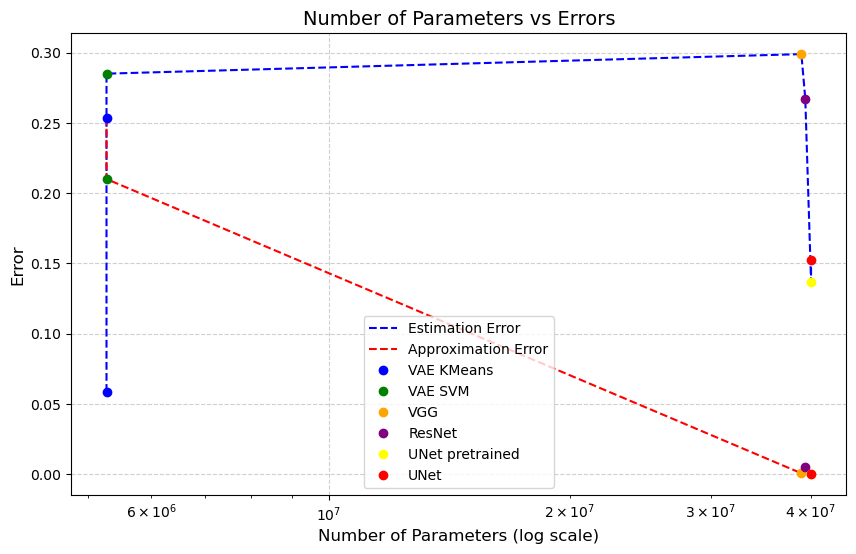

In [26]:
from ClassComp.models.vgg import VGG, Small_VGG
from ClassComp.models.resnet import ResNet
from ClassComp.models.unet import UNet
from ClassComp.models.vae import VAE

vgg = VGG(32,1)
svgg = Small_VGG(32, 1)
resnet = ResNet(32)
unet = UNet(32)
vae = VAE(32**2, 32**2, 8)

print(f"VGG: {count_trainable_parameters(vgg)}")
print(f"Small VGG: {count_trainable_parameters(svgg)}")
print(f"Resnet: {count_trainable_parameters(resnet)}")
print(f"UNet: {count_trainable_parameters(unet)}")
print(f"VAE: {count_trainable_parameters(vae)}")


import matplotlib.pyplot as plt

# Example data
errors = {
    'VAE KMeans': [0.0586, 0.2536],
    'VAE SVM': [0.2850000000000001, 0.20999999999999996],
    
    'VGG': [0.2989, 0.0006000000000000005],
    'ResNet': [0.2672, 0.005400000000000005],
    'UNet pretrained': [0.13679999999999998, 0.0],
    'UNet': [0.15259999999999999, 0.0],
    
}

parameters = {
    'VAE KMeans': count_trainable_parameters(vae) - 18,
    'VAE SVM': count_trainable_parameters(vae),
    
    'VGG': count_trainable_parameters(vgg),  # Replace with actual number of parameters
    'ResNet': count_trainable_parameters(resnet),
    'UNet pretrained': count_trainable_parameters(unet),
    'UNet': count_trainable_parameters(unet),
}

models = list(errors.keys())
param_values = [parameters[model] for model in models]
estimation_errors = [errors[model][0] for model in models]
approximation_errors = [errors[model][1] for model in models]

# Colors for each model
colors = ['blue', 'green', 'orange', 'purple', 'yellow', 'red']

# Plot
plt.figure(figsize=(10, 6))

plt.plot(param_values, estimation_errors, '--', label='Estimation Error', color='blue')
plt.plot(param_values, approximation_errors, '--', label='Approximation Error', color='red')


for i, model in enumerate(models):
    plt.plot(param_values[i], estimation_errors[i], 'o', color=colors[i], label=f'{model}')
    plt.plot(param_values[i], approximation_errors[i], 'o', color=colors[i])

# Add labels and title
plt.xlabel('Number of Parameters (log scale)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Number of Parameters vs Errors', fontsize=14)
plt.xscale('log')  # Use log scale for parameters
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='best')

# Show plot
# plt.savefig("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/image/tradeoff.png", bbox_inches="tight", dpi=300)
plt.show()

In [23]:
with open("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/errors/final_averages_our_models.pkl", "wb") as f:
    pickle.dump(final_averages, f)
    f.close()

In [24]:
with open("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/errors/final_averages_our_models.pkl", "rb") as f:
    d = pickle.load(f)
    f.close()
d

{'VGG': [0.18050000000000002, 0.0],
 'ResNet': [0.49400000000000005, 0.00012499999999999735],
 'UNet pretrained': [0.505, 0.0],
 'UNet': [0.0, 0.0],
 'VAE SVM': [0.2850000000000001, 0.20999999999999996],
 'VAE KMeans': [-0.0012499999999999734, 0.49624999999999997]}

In [18]:
from ClassComp.models.vae import VAE
from ClassComp.data_utils.loaders import get_mnist, get_dataloader
from ClassComp.utils.wasserstein import replicated_slice_wasserstein_generic, get_original_and_reconstructed_images
# Get binary MNIST subsets
train_subset, test_subset = get_mnist()

# Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, size=64, batch_size=8)

model = VAE(64**2, 32**2, 8).to("cuda")
model.load_state_dict(torch.load("/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/models/vae_20_epochs_0.001_lr_vanilla_generation.pth.tar", map_location="cuda"))

d = get_original_and_reconstructed_images(model, test_loader, "cuda")

print(
    f"The SWD on 0s {replicated_slice_wasserstein_generic(d['original_0'], d['reconstructed_0'], n_samples=100, n_slices=100, n_rep=10)} \n"
    f"The SWD on 1s {replicated_slice_wasserstein_generic(d['original_1'], d['reconstructed_1'], n_samples=100, n_slices=100, n_rep=10)} \n"
)


/tmp/ipykernel_387914/1275535126.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/leo/Programmation/Python/AML_project/ML_Model_C

The SWD on 0s 0.06515990345453593 
The SWD on 1s 0.03953195933277586 



In [19]:
print(
    f"The SWD between 0 and 1 {replicated_slice_wasserstein_generic(d['original_0'], d['original_1'], n_samples=100, n_slices=100, n_rep=10)} \n"
)

The SWD between 0 and 1 0.15206970941288656 



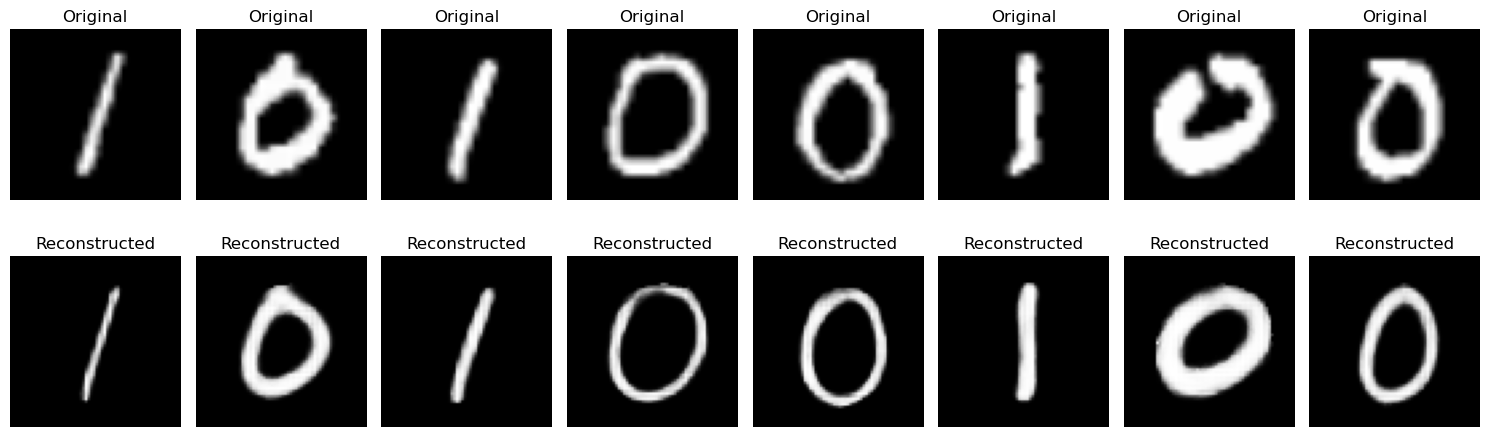

In [9]:
from ClassComp.utils.visualization import plot_vae_outputs

plot_vae_outputs(model, test_loader)


In [27]:
from ClassComp.experiments.error_analysis import get_bayes_risk
import numpy as np

r_star = get_bayes_risk(mu_0, sigma_0, mu_1, sigma_1, test_loader)
r_star

0.252

In [23]:
len(train_loader)

10

In [26]:
from ClassComp.experiments.train import train_binary_classifier, train_vae, train_vae_kmeans
from ClassComp.data_utils.synthetic_data import generate_synthetic_dataset
from ClassComp.data_utils.loaders import get_dataloader
from ClassComp.models.vae import VAE, SVMLoss

mu_0 = - 0.5
mu_1 = 0.5
sigma_0 = sigma_1 = 3
image_size= 32
dataset_size = 10
batch_size = 1
epochs=5
train_subset = generate_synthetic_dataset(
        size=dataset_size, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1, image_size=image_size, seed=1
    )
test_subset = generate_synthetic_dataset(
    size=100 * dataset_size, mu_0=mu_0, sigma_0=sigma_0, mu_1=mu_1, sigma_1=sigma_1, image_size=image_size, seed=2
)

# Load datasets
train_loader, test_loader = get_dataloader(
    train_subset=train_subset,
    test_subset=test_subset,
    transform=None,
    size=image_size,
    batch_size=batch_size,
)

# vae = VAE(image_size**2, 32*32, 8, beta=0.05)
# train_vae(vae, test_loader, test_loader, epochs=epochs)

# vae.classification_mode = "SVM"
# # Train VAE classification head
# criterion = SVMLoss()
# for param in vae.parameters():
#     param.requires_grad = False
# for name, param in vae.named_parameters():
#     if "svm_layer" in name:
#         param.requires_grad = True

# train_binary_classifier(vae, test_loader, test_loader, criterion=criterion, epochs=epochs)

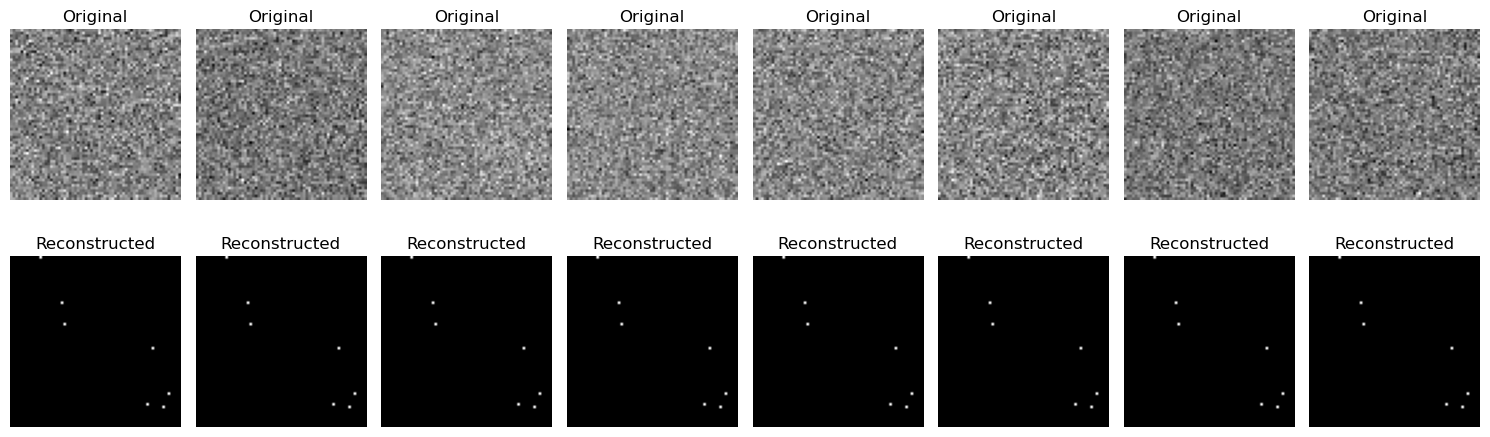

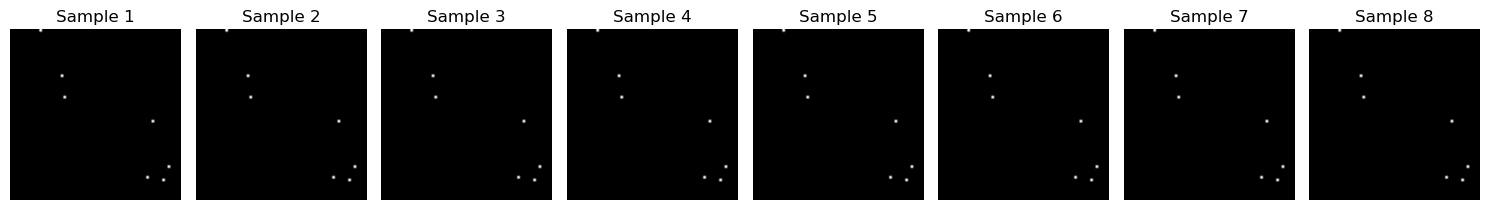

In [8]:
from ClassComp.utils.visualization import plot_vae_tsne_with_svm_boundary, plot_vae_outputs, plot_vae_samples
vae.classification_mode = None
plot_vae_outputs(vae, test_loader)

plot_vae_samples(vae)

### Training monitoring

In [ ]:
import torch
from torchvision import transforms
import gc

from ClassComp.models.vgg import VGG
from ClassComp.models.resnet import ResNet
from ClassComp.models.unet import UNet
from ClassComp.models.vae import VAE, SVMLoss, VAE_conv
from ClassComp.data_utils.loaders import get_mnist, get_dataloader
from ClassComp.experiments.train import train_binary_classifier, train_vae, train_vae_kmeans

def del_model(model):
    del model
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()

# Vanilla training

image_size = 64
batch_size = 16
custom_transforms = None
epochs = 20
learning_rates = [1e-5]
description = "vanilla"

## Get binary MNIST subsets
train_subset, test_subset = get_mnist()

## Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, transform=custom_transforms, size=image_size, batch_size=batch_size)

## Train
# for i, lr in enumerate(learning_rates):
    # print("Training VGG")
    # vgg = VGG(input_img_size=image_size, input_img_c=1)
    # train_binary_classifier(vgg, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    # if i == 0:
    #     torch.save(vgg.state_dict(), f"./results/models/vgg_{epochs}_epochs_{lr}_lr_{description}.pth.tar")

#     del_model(vgg)

    # print("Training Resnet")
    # resnet = ResNet(input_img_size=image_size, input_img_c=1)
    # train_binary_classifier(resnet, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    # if i == 0:
    #     resnet_path = f"./results/models/resnet_{epochs}_epochs_{lr}_lr_{description}.pth.tar"
    #     torch.save(resnet.state_dict(), resnet_path)

    # del_model(resnet)

    # print("Training Unet")
    # for j in range(2):
    #     if j == 0:
    #         resnet = ResNet(input_img_size=image_size, input_img_c=1)  
    #         unet_description = description + "_pretrained_resnet"
    #         resnet.load_state_dict(torch.load(resnet_path))
    #         resnet.eval()
    #         resnet.to("cuda")
    #         unet = UNet(image_size, resnet)
    #     else:
    #         unet_description = description + "no_pretraining"
    #         unet = UNet(image_size)
        
        
    #     train_binary_classifier(unet, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=unet_description)

    #     if i == 0:
    #         torch.save(unet.state_dict(), f"./results/models/unet_{epochs}_epochs_{lr}_lr_{unet_description}.pth.tar")

    #     del_model(unet)

    # print("Training VAE")
    # # for j in range(2):
    # vae = VAE(image_size**2, 32*32, 8, beta=0.05)
    #     # if j == 0:
    #     #     resnet = ResNet(input_img_size=image_size, input_img_c=1)  
    #     #     resnet.load_state_dict(torch.load(resnet_path))
    #     #     resnet.eval()
    #     #     resnet.to("cuda")
    #     #     vae = VAE_conv(image_size, resnet)
    #     #     vae_description = description + "_pretrained_resnet"
    #     # else:
    #     #     vae_description = description + "no_pretraining"
    #     #     vae = VAE_conv(image_size)

    # train_vae(vae, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    # if i == 0:
    #     torch.save(vae.state_dict(), f"./results/models/vae_{epochs}_epochs_{lr}_lr_{description}_generation.pth.tar")

    # vae.classification_mode = "SVM"

    # # Train VAE classification head
    # criterion = SVMLoss()
    # for param in vae.parameters():
    #     param.requires_grad = False
    # for name, param in vae.named_parameters():
    #     if "svm_layer" in name:
    #         param.requires_grad = True
    # train_binary_classifier(vae, train_loader, test_loader, criterion=criterion, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    # if i == 0:
    #     torch.save(vae.state_dict(), f"./results/models/vae_{epochs}_epochs_{lr}_lr_{description}_classification.pth.tar")

    # del_model(vae)

# Noisy training

image_size = 64
batch_size = 16

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
custom_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # 50% chance of vertical flip
    transforms.RandomAffine(
        degrees=30,                          # Random rotation within ±30 degrees
        translate=(0.1, 0.1),                # Random translation up to 10% of image size
        scale=(0.9, 1.1),                    # Random scaling between 90% and 110%
        shear=10                             # Random shear within ±10 degrees
    ),
    transforms.RandomPerspective(
        distortion_scale=0.5,                # Distortion scale for perspective transform
        p=0.5                                # 50% chance of applying
    ),
    transforms.RandomErasing(
        p=0.5,                               # 50% chance of applying
        scale=(0.02, 0.2),                   # Proportion of erased area
        ratio=(0.3, 3.3),                    # Aspect ratio of erased area
        value=0                              # Fill value for erased pixels
    ),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Add Gaussian Blur
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Adjust sharpness
    AddGaussianNoise(),
])
epochs = 20
learning_rates = [1e-3]
description = "class_imbalance"

## Get binary MNIST subsets
train_subset, test_subset = get_mnist()

## Get DataLoaders with additional transformations
train_loader, test_loader = get_dataloader(train_subset, test_subset, transform=None, size=image_size, batch_size=batch_size, class_imbalance=0.9)

## Train
for i, lr in enumerate(learning_rates):
    print("Training VGG")
    vgg = VGG(input_img_size=image_size, input_img_c=1)
    train_binary_classifier(vgg, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    if i == 0:
        torch.save(vgg.state_dict(), f"./results/models/vgg_{epochs}_epochs_{lr}_lr_{description}.pth.tar")

    del_model(vgg)

    print("Training Resnet")
    resnet = ResNet(input_img_size=image_size, input_img_c=1)
    train_binary_classifier(resnet, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    if i == 0:
        resnet_path = f"./results/models/resnet_{epochs}_epochs_{lr}_lr_{description}.pth.tar"
        torch.save(resnet.state_dict(), resnet_path)

    del_model(resnet)

    print("Training Unet")
    for j in range(2):
        if j == 0:
            resnet = ResNet(input_img_size=image_size, input_img_c=1)  
            unet_description = description + "_pretrained_resnet"
            resnet.load_state_dict(torch.load(resnet_path))
            resnet.eval()
            resnet.to("cuda")
            unet = UNet(image_size, resnet)
        else:
            unet_description = description + "no_pretraining"
            unet = UNet(image_size)

        train_binary_classifier(unet, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=unet_description)

        if i == 0:
            torch.save(unet.state_dict(), f"./results/models/unet_{epochs}_epochs_{lr}_lr_{unet_description}.pth.tar")

        del_model(unet)

    print("Training VAE")
    # for j in range(2):
    vae = VAE(image_size**2, 32*32, 8, beta=0.05)
        # if j == 0:
        #     resnet = ResNet(input_img_size=image_size, input_img_c=1)  
        #     resnet.load_state_dict(torch.load(resnet_path))
        #     resnet.eval()
        #     resnet.to("cuda")
        #     vae = VAE_conv(image_size, resnet)
        #     vae_description = description + "_pretrained_resnet"
        # else:
        #     vae_description = description + "no_pretraining"
        #     vae = VAE_conv(image_size)

    train_vae(vae, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    if i == 0:
        torch.save(vae.state_dict(), f"./results/models/vae_{epochs}_epochs_{lr}_lr_{description}_generation.pth.tar")

    vae.classification_mode = "SVM"

    # Train VAE classification head
    criterion = SVMLoss()
    for param in vae.parameters():
        param.requires_grad = False
    for name, param in vae.named_parameters():
        if "svm_layer" in name:
            param.requires_grad = True
    train_binary_classifier(vae, train_loader, test_loader, criterion=criterion, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=description)

    if i == 0:
        torch.save(vae.state_dict(), f"./results/models/vae_{epochs}_epochs_{lr}_lr_{description}_classification.pth.tar")

    train_vae_kmeans(vae, train_loader, test_loader, "cuda", True, description)


    del_model(vae)

    # print("Training VAE")
    # for j in range(2):
    #     resnet = ResNet(input_img_size=image_size, input_img_c=1)  
    #     if j == 0:
    #         resnet = ResNet(input_img_size=image_size, input_img_c=1)  
    #         resnet.load_state_dict(torch.load(resnet_path))
    #         resnet.eval()
    #         resnet.to("cuda")
    #         vae = VAE_conv(image_size, resnet)
    #         vae_description = description + "_pretrained_resnet"
    #     else:
    #         vae_description = description + "no_pretraining"
    #         vae = VAE_conv(image_size)

    #     train_vae(vae, train_loader, test_loader, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=vae_description)

    #     if i == 0:
    #         torch.save(vae.state_dict(), f"./results/models/vae_{epochs}_epochs_{lr}_lr_{vae_description}_generation.pth.tar")

    #     vae.classification_mode = True

    #     # Train VAE classification head
    #     criterion = SVMLoss()
    #     for param in vae.parameters():
    #         param.requires_grad = False
    #     for name, param in vae.named_parameters():
    #         if "svm_layer" in name:
    #             param.requires_grad = True
    #     train_binary_classifier(vae, train_loader, test_loader, criterion=criterion, epochs=epochs, learning_rate=lr, device="cuda", save_results=True, description=vae_description)

    #     if i == 0:
    #         torch.save(vae.state_dict(), f"./results/models/vae_{epochs}_epochs_{lr}_lr_{vae_description}_classification.pth.tar")

    #     del_model(vae)

Training VAE


Epoch [1/20], Training Loss: 58403.6508, Reconstruction Loss: 58378.3490, KLD Loss: 506.0357, Time: 15.40s, Gradient Norm: 2.0402
Epoch [1/20], Validation Loss: 56587.6938, Validation Recon: 56570.2873, Validation KLD: 348.1263


Epoch [2/20], Training Loss: 56937.3357, Reconstruction Loss: 56918.2974, KLD Loss: 380.7629, Time: 28.71s, Gradient Norm: 1.9979
Epoch [2/20], Validation Loss: 55686.9130, Validation Recon: 55665.9393, Validation KLD: 419.4764


KeyboardInterrupt: 

/tmp/ipykernel_9530/3824434198.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("tab20b", num_runs)  # Use 'tab10' colormap with one color per run


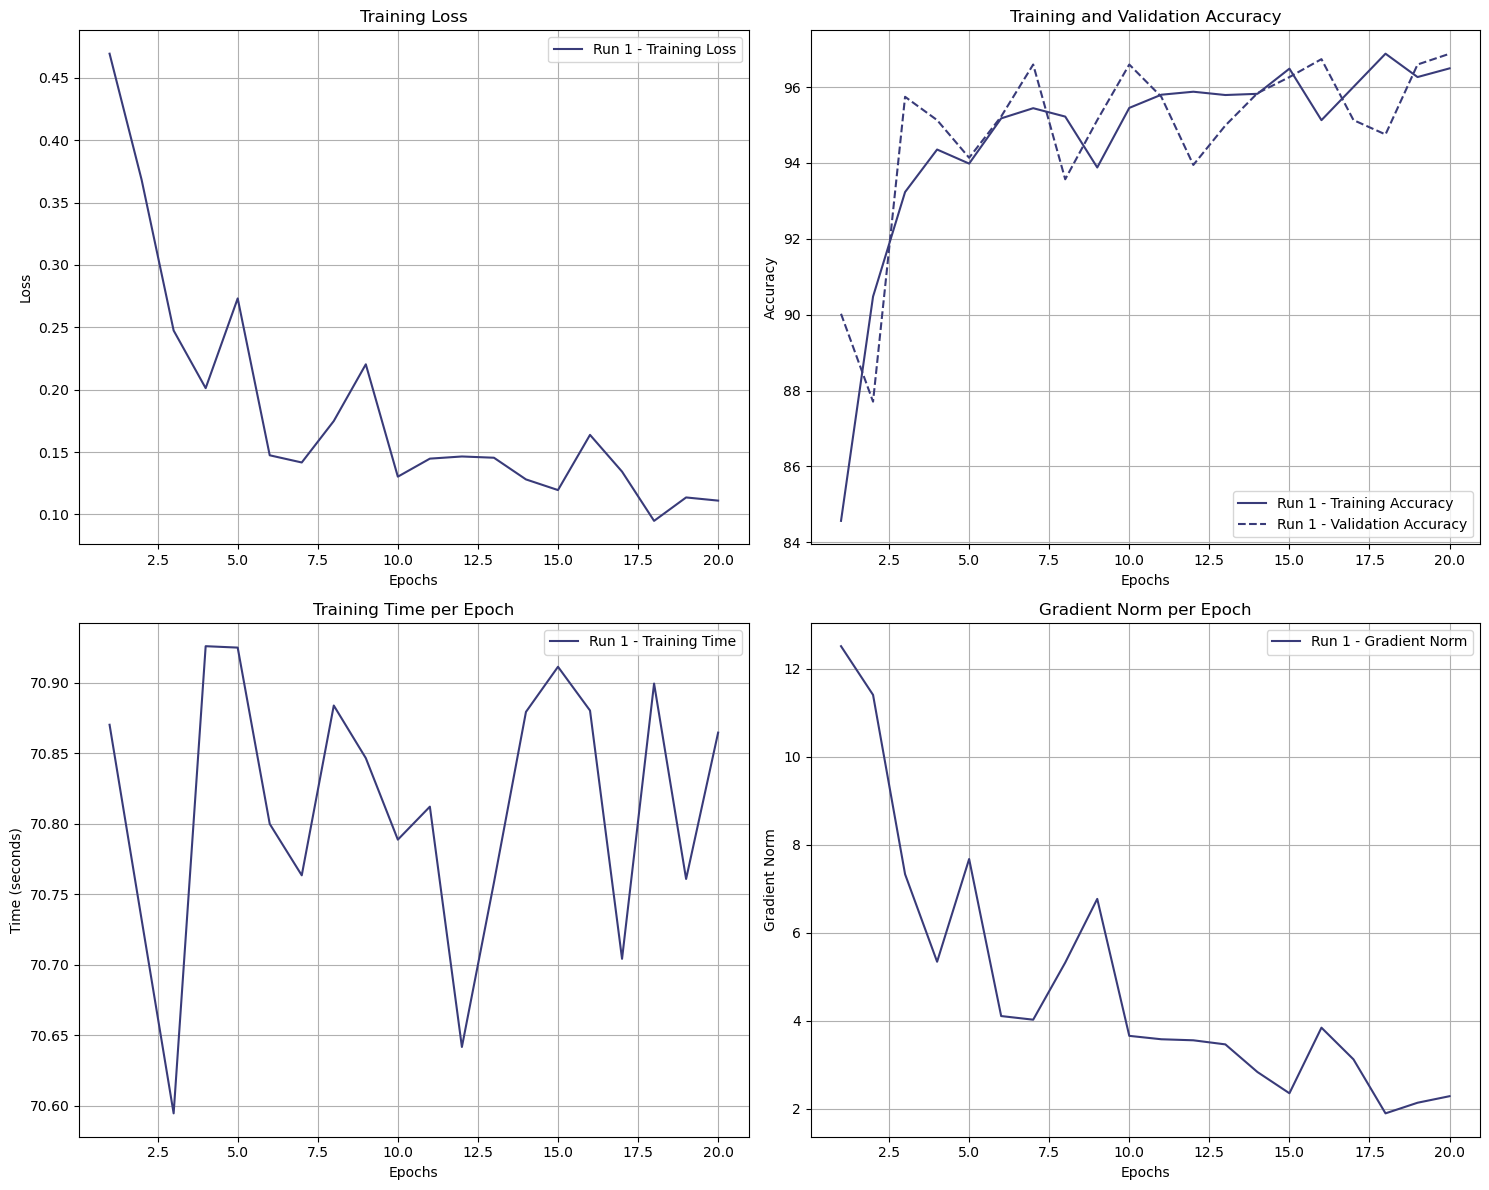

In [27]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm


path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/ResNet_20_epochs_0.001_lr_noisy.pkl"
with open(path, "rb") as f:
    d = pickle.load(f)
    f.close()


def plot_training_metrics(metrics_list):
    """
    Plots training metrics from a list of dictionaries.
    
    Args:
        metrics_list (list): List of dictionaries containing training metrics.
            Each dictionary should have keys:
                - 'name': A string representing the name of the training run.
                - 'training_loss': List of training loss values.
                - 'training_accuracy': List of training accuracy values.
                - 'validation_accuracy': List of validation accuracy values.
                - 'training_time': List of training time values per epoch.
                - 'gradient_norm': List of gradient norms per epoch.
    """
    if not metrics_list:
        print("No metrics provided for plotting.")
        return
    
    # Generate a consistent color map for all runs
    num_runs = len(metrics_list)
    color_map = cm.get_cmap("tab20b", num_runs)  # Use 'tab10' colormap with one color per run

    # Prepare figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    loss_ax, acc_ax, time_ax, grad_ax = axes.flatten()

    for idx, metrics in enumerate(metrics_list):
        name = metrics.get("name", f"Run {idx + 1}")
        color = color_map(idx)  # Get the color for this run
        epochs = list(range(1, len(metrics['training_loss']) + 1))
        
        # Plot training loss
        loss_ax.plot(epochs, metrics['training_loss'], label=f"{name} - Training Loss", color=color)
        
        # Plot training and validation accuracy
        acc_ax.plot(epochs, metrics['training_accuracy'], label=f"{name} - Training Accuracy", color=color)
        acc_ax.plot(epochs, metrics['validation_accuracy'], linestyle='--', label=f"{name} - Validation Accuracy", color=color)
        
        # Plot training time per epoch
        time_ax.plot(epochs, metrics['training_time'], label=f"{name} - Training Time", color=color)
        
        # Plot gradient norm per epoch
        grad_ax.plot(epochs, metrics['gradient_norm'], label=f"{name} - Gradient Norm", color=color)
    
    # Set titles and labels for each plot
    loss_ax.set_title("Training Loss")
    loss_ax.set_xlabel("Epochs")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend()
    loss_ax.grid(True)
    
    acc_ax.set_title("Training and Validation Accuracy")
    acc_ax.set_xlabel("Epochs")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend()
    acc_ax.grid(True)
    
    time_ax.set_title("Training Time per Epoch")
    time_ax.set_xlabel("Epochs")
    time_ax.set_ylabel("Time (seconds)")
    time_ax.legend()
    time_ax.grid(True)
    
    grad_ax.set_title("Gradient Norm per Epoch")
    grad_ax.set_xlabel("Epochs")
    grad_ax.set_ylabel("Gradient Norm")
    grad_ax.legend()
    grad_ax.grid(True)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()


plot_training_metrics([d])

/tmp/ipykernel_9530/3824434198.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("tab20b", num_runs)  # Use 'tab10' colormap with one color per run


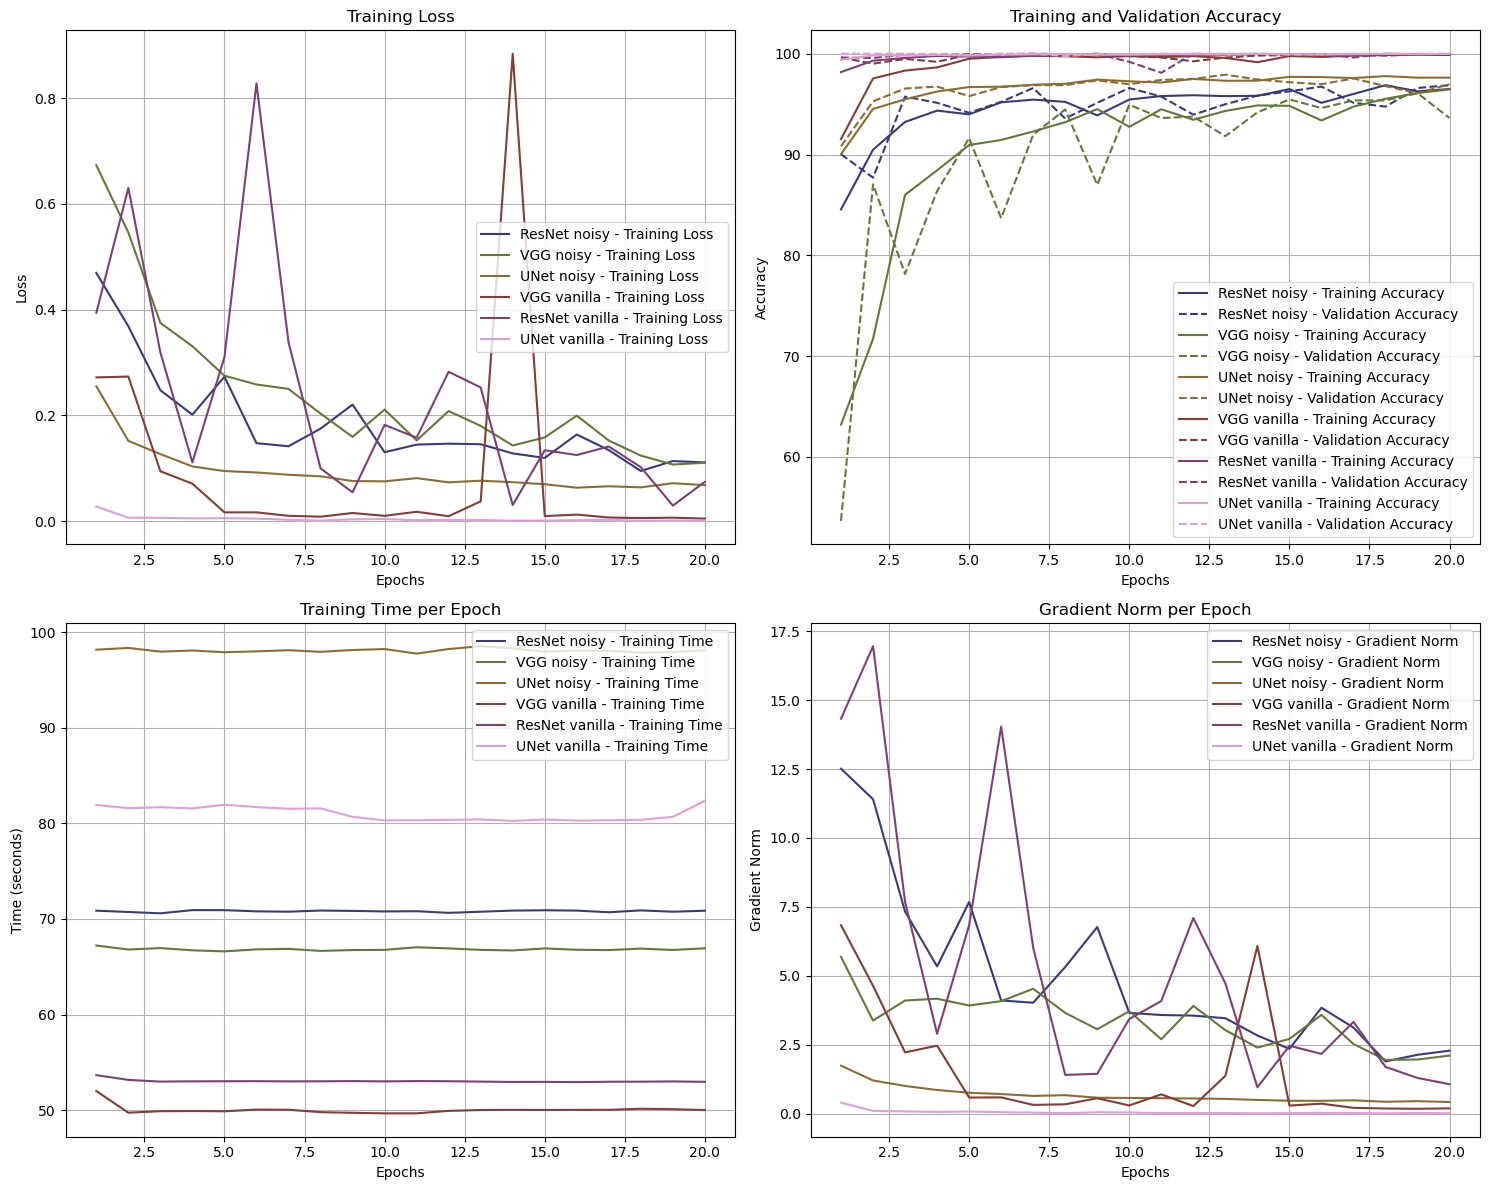

In [29]:
path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/ResNet_20_epochs_0.001_lr_noisy.pkl"
with open(path, "rb") as f:
    d1 = pickle.load(f)
    f.close()
d1["name"] = "ResNet noisy"

path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/ResNet_20_epochs_0.001_lr_vanilla.pkl"
with open(path, "rb") as f:
    d2 = pickle.load(f)
    f.close()
d2["name"] = "ResNet vanilla"

path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/VGG_20_epochs_0.001_lr_noisy.pkl"
with open(path, "rb") as f:
    d3 = pickle.load(f)
    f.close()
d3["name"] = "VGG noisy"

path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/VGG_20_epochs_0.001_lr_vanilla.pkl"
with open(path, "rb") as f:
    d4 = pickle.load(f)
    f.close()
d4["name"] = "VGG vanilla"

path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/UNet_20_epochs_0.001_lr_noisyno_pretraining.pkl"
with open(path, "rb") as f:
    d5 = pickle.load(f)
    f.close()
d5["name"] = "UNet noisy"

path = "/home/leo/Programmation/Python/AML_project/ML_Model_Comparison/results/training/UNet_20_epochs_0.001_lr_vanillano_pretraining.pkl"
with open(path, "rb") as f:
    d6 = pickle.load(f)
    f.close()
d6["name"] = "UNet vanilla"


plot_training_metrics([d1, d3, d5, d4, d2, d6])

In [18]:
d1["validation_accuracy"]

[90.02364066193853,
 87.70685579196217,
 95.74468085106383,
 95.13002364066193,
 94.13711583924349,
 95.22458628841608,
 96.59574468085107,
 93.56973995271868,
 95.13002364066193,
 96.59574468085107,
 95.74468085106383,
 93.94799054373523,
 94.98817966903073,
 95.83924349881796,
 96.26477541371159,
 96.73758865248227,
 95.13002364066193,
 94.7517730496454,
 96.59574468085107,
 96.87943262411348]